<a href="https://colab.research.google.com/github/vaas-umputer/edge-cloud-workflow-scheduler/blob/main/schedler_with_baseline_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torch_geometric stable-baselines3 gym numpy shimmy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18

In [2]:
#defining the GNN model structure
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import Data
import json
import networkx as nx
import numpy as np
from rich.console import Console
import os

class ContrastiveGAT(nn.Module):
    def __init__(self, in_channels=9, hidden_channels=16, embedding_dim=32, heads=4):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.2, add_self_loops=False)
        self.gat2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=0.2, add_self_loops=False)
        self.node_to_embed = nn.Linear(hidden_channels * heads, embedding_dim)
        self.edge_proj = nn.Linear(1, hidden_channels)
        self.graph_fc = nn.Linear(hidden_channels * heads, embedding_dim)

    def forward(self, x, edge_index, edge_attr, batch):
        x = torch.nan_to_num(x, nan=0.0, posinf=1.0, neginf=-1.0)
        edge_attr = torch.ones((edge_index.shape[1], 1), device=x.device) * 0.1 if edge_attr is None else edge_attr
        edge_attr = torch.nan_to_num(edge_attr, nan=0.1)
        edge_attr = self.edge_proj(edge_attr)
        x = F.relu(self.gat1(x, edge_index, edge_attr=edge_attr))
        x = F.dropout(x, p=0.2, training=True)  # Always on for MC Dropout
        x = F.relu(self.gat2(x, edge_index, edge_attr=edge_attr))
        task_embeddings = self.node_to_embed(x)
        graph_embedding = global_mean_pool(x, batch)
        graph_embedding = self.graph_fc(graph_embedding)
        return task_embeddings, graph_embedding

    def contrastive_loss(self, embeddings, edge_index, num_nodes):
        embeddings = torch.nan_to_num(embeddings, nan=0.0)
        if edge_index.shape[1] == 0:
            return torch.tensor(0.0, device=embeddings.device, requires_grad=True)
        pos_pairs = embeddings[edge_index[0]] - embeddings[edge_index[1]]
        pos_loss = (pos_pairs ** 2).sum(dim=1).mean()
        num_neg = min(int(num_nodes * 0.1), 500)
        neg_idx1 = torch.randint(0, num_nodes, (num_neg,), device=embeddings.device)
        neg_idx2 = torch.randint(0, num_nodes, (num_neg,), device=embeddings.device)
        mask = neg_idx1 != neg_idx2
        neg_idx1, neg_idx2 = neg_idx1[mask], neg_idx2[mask]
        if len(neg_idx1) == 0:
            return pos_loss
        neg_pairs = embeddings[neg_idx1] - embeddings[neg_idx2]
        neg_loss = F.relu(1.0 - (neg_pairs ** 2).sum(dim=1)).mean()
        return pos_loss + 0.5 * neg_loss

In [3]:
#class for training the GNN model and other operations
class GNNTrainer:
    def __init__(self, dag_file, embeddings_file, model_file="gnn_model.pth", max_nodes=1000, embedding_dim=32):
        self.dag_file = dag_file
        self.embeddings_file = embeddings_file
        self.model_file = model_file
        self.max_nodes = max_nodes
        self.embedding_dim = embedding_dim
        self.console = Console()
        self.dag = self.load_dag()
        self.model = ContrastiveGAT(embedding_dim=self.embedding_dim)  # Initialize model

    def load_dag(self):
        if not os.path.exists(self.dag_file):
            self.console.log(f"Error: DAG file {self.dag_file} not found")
            raise FileNotFoundError(f"DAG file {self.dag_file} not found")
        with open(self.dag_file, "r") as f:
            dag_json = json.load(f)
        dag = nx.node_link_graph(dag_json, edges="links")
        if len(dag.nodes) > self.max_nodes:
            nodes = list(dag.nodes)[:self.max_nodes]
            dag = dag.subgraph(nodes).copy()
        return dag

    def load_model(self, path):
        self.model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
        self.model.eval()

    def prepare_data(self):
        if not self.dag.nodes:
            x = torch.tensor([[0.5] * 9], dtype=torch.float)
            edge_index = torch.tensor([[], []], dtype=torch.long)
            edge_attr = torch.tensor([[0.1]], dtype=torch.float)
            batch = torch.zeros(1, dtype=torch.long)
            return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, batch=batch)
        node_to_idx = {nid: i for i, nid in enumerate(self.dag.nodes)}
        feature_keys = ["execution_time", "cpu_usage", "memory_usage", "arrival_time", "power_usage", "monetary_cost", "energy_cost"]
        x = [[float(self.dag.nodes[n].get(k, 0.5)) for k in feature_keys] +
             ([1.0, 0.0] if self.dag.nodes[n].get("machine_type", "cloud") == "edge" else [0.0, 1.0])
             for n in self.dag.nodes]
        x = torch.tensor(x, dtype=torch.float)
        x = torch.nan_to_num(x, nan=0.5, posinf=1.0, neginf=0.0)
        mean = x.mean(dim=0)
        std = torch.where(x.std(dim=0) > 0, x.std(dim=0), torch.ones_like(x.std(dim=0)))
        x = (x - mean) / std
        edge_index = torch.tensor([[node_to_idx[e[0]], node_to_idx[e[1]]] for e in self.dag.edges], dtype=torch.long).t() if self.dag.edges else torch.tensor([[], []], dtype=torch.long)
        edge_attr = torch.tensor([[self.dag.edges[e].get("T_comm", 0.1)] for e in self.dag.edges], dtype=torch.float) if self.dag.edges else torch.tensor([[0.1]], dtype=torch.float)
        edge_attr = torch.nan_to_num(edge_attr, nan=0.1)
        batch = torch.zeros(len(self.dag.nodes), dtype=torch.long)
        return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, batch=batch)

    def get_mc_embeddings(self, model, data, num_samples=30):
        model.eval()
        task_embed_samples = []
        for _ in range(num_samples):
            with torch.no_grad():
                task_embeds, _ = model(data.x, data.edge_index, data.edge_attr, data.batch)
                task_embed_samples.append(task_embeds.unsqueeze(0))
        task_embed_samples = torch.cat(task_embed_samples, dim=0)
        task_mean = task_embed_samples.mean(dim=0)
        task_var = task_embed_samples.var(dim=0)
        return task_mean, task_var

    def compute_metrics(self, embeddings, edge_index, task_ids):
        embeddings = embeddings.detach().cpu()
        embeddings = torch.nan_to_num(embeddings, nan=0.0, posinf=1.0, neginf=-1.0)
        embeddings_np = embeddings.numpy()
        pos_sim = neg_sim = emb_var = 0.0
        if edge_index.shape[1] > 0:
            pos_sim = np.mean([
                np.dot(embeddings_np[i], embeddings_np[j]) / (max(np.linalg.norm(embeddings_np[i]), 1e-8) * max(np.linalg.norm(embeddings_np[j]), 1e-8))
                for i, j in zip(edge_index[0].cpu().numpy(), edge_index[1].cpu().numpy())
            ])
        n_samples = min(100, len(task_ids))
        idx1, idx2 = np.random.choice(len(task_ids), (2, n_samples), replace=True)
        mask = idx1 != idx2
        idx1, idx2 = idx1[mask], idx2[mask]
        if len(idx1) > 0:
            neg_sim = np.mean([
                np.dot(embeddings_np[i], embeddings_np[j]) / (max(np.linalg.norm(embeddings_np[i]), 1e-8) * max(np.linalg.norm(embeddings_np[j]), 1e-8))
                for i, j in zip(idx1, idx2)
            ])
        emb_var = np.var(embeddings_np, axis=0).mean() if embeddings_np.size > 0 else 0.0
        return {"pos_sim": pos_sim, "neg_sim": neg_sim, "emb_var": emb_var}

    def save_embeddings(self, data, device):  # New method to generate embeddings without training
        self.model.eval()
        data = data.to(device)
        with torch.no_grad():
            task_mean, task_var = self.get_mc_embeddings(self.model, data)
            task_mean = torch.nan_to_num(task_mean, nan=0.0)
            task_var = torch.nan_to_num(task_var, nan=0.0)
            task_embeddings_dict = {
                nid: {"mean": mean.tolist(), "uncertainty": var.tolist()}
                for nid, mean, var in zip(self.dag.nodes, task_mean, task_var)
            }
            torch.save({"task_embeddings": task_embeddings_dict}, self.embeddings_file)
            self.console.log(f"Saved embeddings to {self.embeddings_file}")

    def train(self, epochs=10):
        self.console.log(f"Training GNN with embedding_dim={self.embedding_dim}...")
        device = "cuda" if torch.cuda.is_available() else "cpu"
        self.console.log(f"Using device: {device}")
        self.model = self.model.to(device)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        data = self.prepare_data().to(device)
        if data.x.shape[0] == 0 or data.edge_index.shape[1] == 0:
            self.console.log("Empty graph, skipping training")
            return
        for epoch in range(1, epochs + 1):
            self.model.train()
            optimizer.zero_grad()
            task_embeddings, _ = self.model(data.x, data.edge_index, data.edge_attr, data.batch)
            loss = self.model.contrastive_loss(task_embeddings, data.edge_index, len(data.x))
            if torch.isnan(loss) or torch.isinf(loss):
                self.console.log(f"Epoch {epoch}: Invalid loss ({loss.item()}), skipping")
                continue
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            optimizer.step()
            if epoch % 2 == 0:
                metrics = self.compute_metrics(task_embeddings, data.edge_index, list(self.dag.nodes))
                self.console.log(
                    f"Epoch {epoch}/{epochs}: Loss={loss.item():.4f}, "
                    f"Pos Sim={metrics['pos_sim']:.4f}, Neg Sim={metrics['neg_sim']:.4f}, "
                    f"Emb Var={metrics['emb_var']:.4f}"
                )
        self.model.eval()
        with torch.no_grad():
            task_mean, task_var = self.get_mc_embeddings(self.model, data)
            task_mean = torch.nan_to_num(task_mean, nan=0.0)
            task_var = torch.nan_to_num(task_var, nan=0.0)
            task_embeddings_dict = {
                nid: {"mean": mean.tolist(), "uncertainty": var.tolist()}
                for nid, mean, var in zip(self.dag.nodes, task_mean, task_var)
            }
            torch.save({"task_embeddings": task_embeddings_dict}, self.embeddings_file)
            self.console.log(f"Saved embeddings and uncertainties to {self.embeddings_file}")
            torch.save(self.model.state_dict(), self.model_file)
            self.console.log(f"Saved GNN model to {self.model_file}")
            metrics = self.compute_metrics(task_mean, data.edge_index, list(self.dag.nodes))
            self.console.log(
                f"Final Metrics: Pos Sim={metrics['pos_sim']:.4f}, Neg Sim={metrics['neg_sim']:.4f}, "
                f"Emb Var={metrics['emb_var']:.4f}"
            )

In [4]:
import torch
import numpy as np
import gymnasium as gym
from gymnasium import Env, spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from rich.console import Console
import json
import networkx as nx
import os
import seaborn as sns
import matplotlib.pyplot as plt
from rich.table import Table

#the task queue used for simulating tasks and their execution
class TaskQueue:
    def __init__(self, dag, embeddings, task_ids, num_servers=5):
        self.dag = dag
        self.task_ids = task_ids
        self.tasks = {
            node: {
                "embedding": embeddings[i] if i < len(embeddings) else np.zeros(embeddings.shape[1]),
                "dependencies": set(dag.predecessors(node)),
                "exec_time": dag.nodes[node].get("execution_time", 1.0),
                "arrival_time": dag.nodes[node].get("arrival_time", 0.0),
                "monetary_cost": dag.nodes[node].get("monetary_cost", 1.0),
                "energy_cost": dag.nodes[node].get("energy_cost", 1.0),
                "placement": None,
                "server": None,
                "history": []
            } for i, node in enumerate(task_ids)
        }
        self.completed = set()
        self.running = {}
        self.server_loads = {"cloud": np.zeros(num_servers), "edge": np.zeros(num_servers)}
        self.edge_battery = np.full(num_servers, 100.0)
        self.network_latency = 0.5
        self.current_time = 0.0
        self.total_cost = 0.0
        self.total_energy = 0.0
        self.console = Console()
        self.cloud_base_power = np.random.uniform(10, 15, num_servers)
        self.edge_base_power = np.random.uniform(2, 5, num_servers)
        self.load_history = {"cloud": [], "edge": []}
        self.placement_log = {}
        self.overload_feedback = {"cloud": False, "edge": False}

    def reset(self):
        self.completed = set()
        self.running = {}
        self.server_loads = {"cloud": np.zeros(len(self.server_loads["cloud"])), "edge": np.zeros(len(self.server_loads["edge"]))}
        self.edge_battery = np.full(len(self.server_loads["edge"]), 100.0)
        self.network_latency = 0.5
        self.current_time = 0.0
        self.total_cost = 0.0
        self.total_energy = 0.0
        self.load_history = {"cloud": [], "edge": []}
        self.placement_log = {}
        for task in self.tasks.values():
            task["placement"] = None
            task["server"] = None
            task["history"] = []

    def update_conditions(self):
        self.network_latency = np.random.uniform(0.3, 0.7)
        self.server_loads["cloud"] += np.random.uniform(0, 0.2, len(self.server_loads["cloud"]))
        self.server_loads["edge"] += np.random.uniform(0, 0.1, len(self.server_loads["edge"]))
        self.server_loads["cloud"] = np.clip(self.server_loads["cloud"], 0, 2.0)
        self.server_loads["edge"] = np.clip(self.server_loads["edge"], 0, 1.5)
        self.edge_battery += 0.5
        self.edge_battery = np.clip(self.edge_battery, 0, 100)
        self.load_history["cloud"].append(self.server_loads["cloud"].copy())
        self.load_history["edge"].append(self.server_loads["edge"].copy())
        if len(self.load_history["cloud"]) > 10:
            self.load_history["cloud"].pop(0)
            self.load_history["edge"].pop(0)
        self.overload_feedback["cloud"] = np.any(self.server_loads["cloud"] > 2.0)
        self.overload_feedback["edge"] = np.any(self.server_loads["edge"] > 1.5) or np.any(self.edge_battery < 20)

    def get_ready_tasks(self):
        ready = [tid for tid, t in self.tasks.items() if
                 tid not in self.running and tid not in self.completed and
                 t["arrival_time"] <= self.current_time and
                 t["dependencies"].issubset(self.completed)]
        if not ready and self.running:
            stuck_tasks = [tid for tid in self.running if self.current_time - self.running[tid]["expected_end"] > 10.0]
            if stuck_tasks:
                self.console.log(f"Stuck tasks detected: {stuck_tasks[:5]}")
            self.console.log(f"Waiting for running tasks: {list(self.running.keys())[:5]}")
        return ready

    def update_running(self):
        completed = [t for t, info in self.running.items() if self.current_time >= info["expected_end"]]
        for task in completed:
            self.complete_task(task)
        self.edge_battery = np.minimum(self.edge_battery + 0.5, 100.0)
        if not completed and self.running:
            self.current_time += 0.5
            if hasattr(self, 'active_phase') and self.active_phase:
                self.console.log(f"Advancing time to {self.current_time:.2f} due to running tasks")

    def clear_running(self):
        for task in list(self.running.keys()):
            self.complete_task(task)
        self.running.clear()
        self.current_time = max(self.current_time, 0.0)

    def start_task(self, task_id, placement, server, exec_time):
        if task_id not in self.tasks:
            self.console.log(f"Task {task_id} not found")
            return
        exec_time = min(exec_time, 10.0)
        energy = 0
        if placement == "cloud":
            base_power = self.cloud_base_power[server]
            load_factor = min(self.server_loads[placement][server] / 3.0, 0.4)
            energy = (base_power + load_factor * 5) * exec_time
        elif placement == "edge":
            base_power = self.edge_base_power[server]
            load_factor = min(self.server_loads[placement][server] / 2.0, 0.4)
            energy = (base_power + load_factor * 5) * exec_time
            self.edge_battery[server] -= energy
            self.edge_battery[server] = max(0.0, self.edge_battery[server])
        self.server_loads[placement][server] += self.tasks[task_id]["exec_time"] / (3.0 if placement == "cloud" else 2.0)
        self.running[task_id] = {
            "placement": placement,
            "server": server,
            "expected_end": self.current_time + exec_time,
            "energy": energy,
            "exec_time": exec_time
        }
        self.placement_log[task_id] = {"placement": placement, "server": server}

    def complete_task(self, task_id):
        if task_id not in self.running:
            self.console.log(f"Task {task_id} not running")
            return
        task_info = self.running[task_id]
        exec_time = task_info["exec_time"]
        placement = task_info["placement"]
        server = task_info["server"]
        self.server_loads[placement][server] = max(0, self.server_loads[placement][server] - exec_time * 0.1)
        base_power = self.cloud_base_power[server] if placement == "cloud" else self.edge_base_power[server]
        load_factor = min(self.server_loads[placement][server] / (2.0 if placement == "cloud" else 1.5), 0.4)
        energy = (base_power + load_factor * 5) * exec_time
        cost = exec_time * (0.10 if placement == "cloud" else 0.05)
        sla_deadline = self.tasks[task_id]["exec_time"] * 1.5
        sla_met = 1 if exec_time <= sla_deadline else 0
        self.total_energy += energy
        self.total_cost += cost
        self.tasks[task_id]["history"].append({
            "exec_time": exec_time,
            "energy": energy,
            "cost": cost,
            "sla": sla_met,
            "placement": placement,
            "server": server,
            "timestamp": self.current_time
        })
        self.completed.add(task_id)
        del self.running[task_id]

    def get_historical_state(self, task_id):
        history = self.tasks[task_id]["history"]
        return np.array([1.0, 0.8, 0.5, 0.0, 1.0]) if not history else np.array([
            history[-1]["exec_time"],
            history[-1]["energy"],
            history[-1]["cost"],
            history[-1]["sla"],
            1 if history[-1]["placement"] == "cloud" else 0
        ])

    def predict_load(self, placement):
        history = self.load_history[placement]
        return np.mean(history, axis=0) if history else self.server_loads[placement]

In [5]:
#the tier 1 model of HRL
class Tier1SchedulerEnv(Env):
    def __init__(self, task_queue, embeddings, task_ids, embeddings_var=None):
        super().__init__()
        self.task_queue = task_queue
        self.embeddings = embeddings
        self.task_ids = task_ids
        self.embeddings_var = embeddings_var  # NEW: Add embeddings_var parameter
        self.action_space = spaces.MultiBinary(5)
        emb_dim = embeddings.shape[1]
        system_state_dim = 19
        historical_dim = 5
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=((emb_dim + system_state_dim + historical_dim) * 5,), dtype=np.float32)
        self.max_exec_time = 10.0
        self.console = Console()
        self.seed_value = None

    def reset(self, seed=None, options=None):
        if seed is not None:
            self.seed_value = seed
            np.random.seed(seed)
        self.task_queue.reset()
        obs = self._get_obs()
        if obs.shape != self.observation_space.shape:
            self.console.log(f"Observation shape mismatch: got {obs.shape}, expected {self.observation_space.shape}")
        return obs, {"reset": True}

    def _get_obs(self):
        ready_tasks = self.task_queue.get_ready_tasks()[:5]
        emb_dim = self.embeddings.shape[1]
        task_obs_dim = emb_dim + 19 + 5
        obs = []
        for i in range(5):
            if i < len(ready_tasks):
                tid = ready_tasks[i]
                if tid not in self.task_ids:
                    obs.append(np.zeros(task_obs_dim))
                    continue
                idx = self.task_ids.index(tid)
                emb = np.nan_to_num(self.embeddings[idx], nan=0.0)
                system_state = np.concatenate([
                    [self.task_queue.current_time, len(self.task_queue.running), len(ready_tasks), self.task_queue.network_latency],
                    self.task_queue.server_loads["cloud"],
                    self.task_queue.server_loads["edge"],
                    self.task_queue.edge_battery
                ])
                historical_state = self.task_queue.get_historical_state(tid)
                obs.append(np.concatenate([emb, system_state, historical_state]))
            else:
                obs.append(np.zeros(task_obs_dim))
        obs_array = np.concatenate(obs).astype(np.float32)
        return obs_array

    def step(self, action):
        self.task_queue.update_running()
        ready_tasks = self.task_queue.get_ready_tasks()[:5]
        if not ready_tasks:
            self.task_queue.current_time += 0.5
            return self._get_obs(), 0, False, False, {"placements": {}}
        self.task_queue.update_conditions()
        placements = {}
        total_reward = 0
        cloud_count = 0
        for i, tid in enumerate(ready_tasks):
            if i >= len(action):
                break
            placement = "cloud" if action[i] == 0 else "edge"
            if placement == "cloud":
                cloud_count += 1
            base_time = self.task_queue.tasks[tid]["exec_time"]
            exec_time = base_time
            if placement == "edge" and base_time > 5.0 and np.mean(self.task_queue.edge_battery) < 20:
                fragments = int(np.ceil(base_time / 2.0))
                exec_time = base_time / fragments
            load_factor = min(np.mean(self.task_queue.server_loads[placement]) / (2.0 if placement == "cloud" else 1.5), 0.3)
            exec_time *= (1 + load_factor * 0.3 + min(self.task_queue.network_latency * 0.3, 0.5))
            exec_time = min(exec_time, 5.0)
            base_power = np.mean(self.task_queue.cloud_base_power) if placement == "cloud" else np.mean(self.task_queue.edge_base_power)
            energy = (base_power + load_factor * 5) * exec_time
            cost = exec_time * (0.10 if placement == "cloud" else 0.05)
            sla_met = 1 if exec_time <= base_time * 1.5 else 0
            edge_bonus = 1.0 if placement == "edge" and np.mean(self.task_queue.edge_battery) > 50 else 0.0
            reward = 30.0 * sla_met - 0.1 * (exec_time / 5.0) - 0.05 * (energy / 5.0) - 0.05 * (cost / 10.0) + edge_bonus
            if self.task_queue.overload_feedback[placement]:
                reward -= 0.5
            if self.embeddings_var is not None and placement == "cloud":  # Safe check, works with None
                idx = self.task_ids.index(tid)
                if np.mean(self.embeddings_var[idx]) < 0.05:
                    reward -= 0.5
            total_reward += reward
            placements[tid] = {"placement": placement, "exec_time": exec_time, "energy": energy, "cost": cost}
        cloud_ratio = cloud_count / len(ready_tasks) if ready_tasks else 0.0
        if cloud_ratio < 0.3 or cloud_ratio > 0.7:
            total_reward -= 3.0
        terminated = len(self.task_queue.completed) == len(self.task_ids)
        truncated = False
        return self._get_obs(), total_reward, terminated, truncated, {"placements": placements, "cloud_ratio": cloud_ratio}

In [6]:
#the tier 2 model of HRL
class Tier2SchedulerEnv(Env):
    def __init__(self, task_queue, embeddings, task_ids):
        super().__init__()
        self.task_queue = task_queue
        self.embeddings = embeddings
        self.task_ids = task_ids
        self.action_space = spaces.MultiDiscrete([5] * 5)
        emb_dim = embeddings.shape[1]
        system_state_dim = 19
        historical_dim = 5
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=((emb_dim + system_state_dim + historical_dim) * 5,), dtype=np.float32)
        self.current_tasks = []
        self.placements = {}
        self.max_exec_time = 10.0
        self.console = Console()
        self.seed_value = None

    def reset(self, seed=None, options=None):
        if seed is not None:
            self.seed_value = seed
            np.random.seed(seed)
        self.current_tasks = []
        self.placements = {}
        obs = self._get_obs()
        if obs.shape != self.observation_space.shape:
            self.console.log(f"Observation shape mismatch: got {obs.shape}, expected {self.observation_space.shape}")
        return obs, {"reset": True}

    def _get_obs(self):
        emb_dim = self.embeddings.shape[1]
        task_obs_dim = emb_dim + 19 + 5
        obs = []
        for i in range(5):
            if i < len(self.current_tasks):
                tid = self.current_tasks[i]
                if tid not in self.task_ids:
                    obs.append(np.zeros(task_obs_dim))
                    continue
                idx = self.task_ids.index(tid)
                emb = np.nan_to_num(self.embeddings[idx], nan=0.0)
                system_state = np.concatenate([
                    [self.task_queue.current_time, len(self.task_queue.running), len(self.task_queue.get_ready_tasks()), self.task_queue.network_latency],
                    self.task_queue.server_loads["cloud"],
                    self.task_queue.server_loads["edge"],
                    self.task_queue.edge_battery if self.placements.get(tid) == "edge" else np.zeros(5)
                ])
                historical_state = self.task_queue.get_historical_state(tid)
                obs.append(np.concatenate([emb, system_state, historical_state]))
            else:
                obs.append(np.zeros(task_obs_dim))
        obs_array = np.concatenate(obs).astype(np.float32)
        return obs_array

    def step(self, action):
        if not isinstance(action, np.ndarray) or len(action) != 5:
            return self._get_obs(), 0, False, False, {}
        total_reward = 0
        info_dict = {}
        edge_placements = sum(1 for tid in self.current_tasks if self.placements.get(tid) == "edge")
        cloud_placements = len(self.current_tasks) - edge_placements
        cloud_ratio = cloud_placements / len(self.current_tasks) if self.current_tasks else 0.0
        for i, tid in enumerate(self.current_tasks[:5]):
            if i >= len(action) or tid not in self.task_queue.tasks:
                continue
            server = int(action[i]) % 5
            placement = self.placements.get(tid, "cloud")
            base_time = self.task_queue.tasks[tid]["exec_time"]
            base_time = min(base_time, 5.0)
            exec_time = base_time
            if base_time > 3.0 and self.task_queue.server_loads["cloud"][server] < 1.5:
                placement = "cloud"
            if placement == "edge" and base_time > 5.0 and self.task_queue.edge_battery[server] < 20:
                fragments = int(np.ceil(base_time / 2.0))
                exec_time = base_time / fragments
            predicted_load = self.task_queue.predict_load(placement)
            if predicted_load[server] >= (3.0 if placement == "cloud" else 2.0):
                total_reward -= 1
                continue
            load_factor = min(self.task_queue.server_loads[placement][server] / (3.0 if placement == "cloud" else 2.0), 0.3)
            exec_time *= (1 + load_factor * 0.3 + min(self.task_queue.network_latency * 0.3, 0.5))
            exec_time = min(exec_time, 5.0)
            self.task_queue.start_task(tid, placement, server, exec_time)
            sla_met = 1 if exec_time <= base_time * 1.5 else 0
            base_power = self.task_queue.cloud_base_power[server] if placement == "cloud" else self.task_queue.edge_base_power[server]
            energy = (base_power + load_factor * 5) * exec_time
            cost = exec_time * (0.10 if placement == "cloud" else 0.05)
            load_balance = -0.5 * np.std(self.task_queue.server_loads[placement])
            if cloud_ratio < 0.4:
                load_balance -= 0.7 * np.std(self.task_queue.server_loads["edge"])
                total_reward -= 5.0
            reward = 40.0 * sla_met - 0.05 * (exec_time / 5.0) - 0.02 * (energy / 5.0) - 0.03 * (cost / 10.0) + load_balance
            total_reward += reward
            info_dict[tid] = {"task": tid, "exec_time": exec_time, "energy": energy, "cost": cost, "placement": placement}
        self.task_queue.update_running()
        terminated = len(self.task_queue.completed) == len(self.task_ids)
        truncated = False
        self.current_tasks = []
        self.placements = {}
        return self._get_obs(), total_reward, terminated, truncated, {"tasks": info_dict, "cloud_ratio": cloud_ratio}

In [7]:
#PROPOSED SCHEDULER LOGIC
class WorkflowScheduler:
    def __init__(self, dag_file, embeddings_file, validation_dag_file="balanced_montage_dag.json", max_nodes=1000):
        self.dag_file = dag_file  # CyberShake for training
        self.embeddings_file = embeddings_file  # CyberShake embeddings
        self.validation_dag_file = validation_dag_file  # Montage for validation
        self.max_nodes = max_nodes
        self.console = Console()
        # Load training DAG (CyberShake)
        self.dag, self.embeddings, self.task_ids, self.embeddings_var = self.load_dag_and_embeddings(self.dag_file, self.embeddings_file, is_validation=False)
        self.task_queue = TaskQueue(self.dag, self.embeddings, self.task_ids)
        self.tier1_env = Tier1SchedulerEnv(self.task_queue, self.embeddings, self.task_ids, self.embeddings_var)
        self.tier2_env = Tier2SchedulerEnv(self.task_queue, self.embeddings, self.task_ids)
        self.tier1_model = None
        self.tier2_model = None
        self.metrics = {"hrl": None, "cloud": None, "edge": None}  # Store validation metrics

    def load_dag_and_embeddings(self, dag_file, embeddings_file, is_validation=False):
        if not os.path.exists(dag_file):
            self.console.log(f"Error: DAG file {dag_file} not found")
            raise FileNotFoundError(f"DAG file {dag_file} not found")
        with open(dag_file, "r") as f:
            dag_json = json.load(f)
        dag = nx.node_link_graph(dag_json, edges="links")
        if len(dag.nodes) > self.max_nodes:
            nodes = list(dag.nodes)[:self.max_nodes]
            dag = dag.subgraph(nodes).copy()

        if not os.path.exists(embeddings_file):
            self.console.log(f"Generating embeddings for {dag_file}...")
            trainer = GNNTrainer(dag_file, embeddings_file, embedding_dim=32)
            trainer.dag = dag  # Update DAG to current (CyberShake or Montage)
            if is_validation:
                # Use trained GNN model for Montage
                if not os.path.exists("gnn_model.pth"):
                    self.console.log("Error: gnn_model.pth not found for Montage embeddings")
                    raise FileNotFoundError("gnn_model.pth required for Montage embeddings")
                trainer.load_model("gnn_model.pth")
                data = trainer.prepare_data()
                device = "cuda" if torch.cuda.is_available() else "cpu"
                trainer.save_embeddings(data, device)  # Generate embeddings without training
            else:
                # For CyberShake, create zeros if embeddings don't exist
                task_embeddings_dict = {tid: {"mean": np.zeros(32), "uncertainty": np.zeros(32)} for tid in dag.nodes()}
                torch.save({"task_embeddings": task_embeddings_dict}, embeddings_file)

        embeddings_data = torch.load(embeddings_file, map_location=torch.device('cpu'))
        task_embeddings_dict = embeddings_data["task_embeddings"]
        task_ids = list(dag.nodes())
        task_embeddings = np.array([
            task_embeddings_dict.get(tid, {"mean": np.zeros(32)}).get("mean", np.zeros(32)) for tid in task_ids
        ])
        task_embeddings_var = np.array([
            task_embeddings_dict.get(tid, {"uncertainty": np.zeros(32)}).get("uncertainty", np.zeros(32)) for tid in task_ids
        ])
        embeddings_var = task_embeddings_var if any(np.any(v) for v in task_embeddings_var) else None
        if embeddings_var is None:
            self.console.log(f"Warning: No variance data in embeddings for {dag_file}, uncertainty penalty disabled")
        return dag, task_embeddings, task_ids, embeddings_var

    def print_comparative_metrics(self):
        if not all(self.metrics.values()):
            self.console.log("Error: Not all metrics are available. Ensure validation completed.")
            return

        headers = ["Metric", "HRL", "Cloud-Only", "Edge-Only"]
        metrics_to_display = [
            ("DAG Used", None, "Montage", "Montage", "Montage"),
            ("Makespan (s)", "makespan", "{:.2f}"),
            ("Avg Exec Time (s)", "avg_exec_time", "{:.2f}"),
            ("Avg Energy (units)", "avg_energy", "{:.2f}"),
            ("Avg Cost ($)", "avg_cost", "{:.2f}"),
            ("SLA Compliance (%)", "sla_rate", "{:.2%}"),
            ("Cloud Ratio (%)", "cloud_ratio", "{:.2%}"),
            ("Throughput (tasks/s)", "throughput", "{:.2f}"),
            ("Avg Queue Length", "avg_queue_length", "{:.2f}"),
            ("Cloud Load Balance (std)", "cloud_load_balance", "{:.2f}"),
            ("Edge Load Balance (std)", "edge_load_balance", "{:.2f}"),
            ("Avg Edge Battery (%)", "avg_edge_battery", "{:.2f}"),
            ("Avg Reward", "avg_reward", "{:.2f}"),
            ("Tasks Completed", "completed_count", "{}/{}")
        ]

        table = []
        for row_def in metrics_to_display:
            if len(row_def) == 5:  # Special case for DAG Used
                label, _, hrl_val, cloud_val, edge_val = row_def
                row = [label, hrl_val, cloud_val, edge_val]
            else:
                label, key, fmt = row_def
                row = [label]
                for mode in ["hrl", "cloud", "edge"]:
                    metric = self.metrics[mode]
                    if key == "completed_count":
                        value = fmt.format(metric[key], metric["total_tasks"])
                    else:
                        value = fmt.format(metric[key])
                    row.append(value)
            table.append(row)

        from rich.table import Table
        t = Table(title="Validation Metrics (Training: CyberShake, Validation: Montage)")
        for h in headers:
            t.add_column(h, justify="center")
        for row in table:
            t.add_row(*row)
        self.console.print(t)

    def train_tier1(self, timesteps=20000):
        self.console.log("Training Tier 1...")
        self.tier1_env.task_queue.active_phase = True
        self.tier1_model = PPO("MlpPolicy", DummyVecEnv([lambda: self.tier1_env]), verbose=0, n_steps=256, ent_coef=0.05)
        self.tier1_model.learn(total_timesteps=timesteps)
        self.tier1_model.save("tier1_scheduler_new")  # NEW: Fix filename to match validate
        self.tier1_env.task_queue.clear_running()
        self.tier1_env.task_queue.active_phase = False
        self.console.log("Tier 1 training complete, saved to tier1_scheduler.zip")

    def train_tier2(self, timesteps=20000):
        self.console.log("Training Tier 2...")
        self.tier1_env.reset()
        self.tier2_env.reset()
        self.tier1_env.task_queue.clear_running()
        self.tier2_env.task_queue.clear_running()
        self.tier1_env.task_queue.active_phase = True
        self.tier2_env.task_queue.active_phase = True
        try:
            self.tier1_model = PPO.load("tier1_scheduler_new")  # NEW: Match train_tier1 filename
        except FileNotFoundError:
            self.console.log("Tier 1 model not found, training Tier 1 first...")
            self.train_tier1(timesteps=5000)
        self.tier2_model = PPO("MlpPolicy", DummyVecEnv([lambda: self.tier2_env]), verbose=0, n_steps=256, ent_coef=0.05)
        obs = self.tier1_env.reset()[0]
        total_steps = timesteps // 128
        steps_taken = 0
        while steps_taken < total_steps and len(self.tier1_env.task_queue.completed) < len(self.task_ids):
            ready_tasks = self.tier1_env.task_queue.get_ready_tasks()
            if not ready_tasks and not self.tier1_env.task_queue.running:
                future_arrivals = [t["arrival_time"] for t in self.tier1_env.task_queue.tasks.values()
                                   if t["arrival_time"] > self.tier1_env.task_queue.current_time
                                   and t["dependencies"].issubset(self.tier1_env.task_queue.completed)]
                if future_arrivals:
                    self.tier1_env.task_queue.current_time = min(future_arrivals)
                    self.tier2_env.task_queue.current_time = self.tier1_env.task_queue.current_time
                    continue
                incomplete = [tid for tid in self.task_ids if tid not in self.tier1_env.task_queue.completed]
                if incomplete:
                    dep_issues = [(tid, list(self.tier1_env.task_queue.tasks[tid]["dependencies"] - self.tier1_env.task_queue.completed))
                                  for tid in incomplete[:5]]
                    self.console.log(f"No ready tasks, incomplete: {incomplete[:10]}, dependencies: {dep_issues}")
                break
            action = np.zeros(5, dtype=int)
            for i in range(min(5, len(ready_tasks))):
                action[i] = self.tier1_model.predict(obs, deterministic=False)[0][i]
            obs, reward, _, _, info = self.tier1_env.step(action)
            if info["placements"]:
                self.tier2_env.current_tasks = list(info["placements"].keys())
                self.tier2_env.placements = {tid: info["placements"][tid]["placement"] for tid in info["placements"]}
                tier2_obs = self.tier2_env._get_obs()
                tier2_action = self.tier2_model.predict(tier2_obs, deterministic=False)[0]
                tier2_obs, reward2, done, _, tier2_info = self.tier2_env.step(tier2_action)
                if tier2_info["tasks"]:
                    self.tier2_model.learn(total_timesteps=128, reset_num_timesteps=False)
                    steps_taken += 1
            self.tier1_env.task_queue.update_running()
            self.tier2_env.task_queue.update_running()
            obs = self.tier1_env._get_obs()
        self.tier2_model.save("tier2_scheduler_new")  # NEW: Fix filename to match validate
        self.tier1_env.task_queue.active_phase = False
        self.tier2_env.task_queue.active_phase = False
        self.console.log("Tier 2 training complete, saved to tier2_scheduler.zip")

    def validate(self, baseline=False, mode="hrl"):
        validation_embeddings_file = "montage_embeddings.pth"
        if not os.path.exists(self.validation_dag_file):
            self.console.log(f"Error: Validation DAG file {self.validation_dag_file} not found")
            return None

        validation_dag, validation_embeddings, validation_task_ids, validation_embeddings_var = self.load_dag_and_embeddings(
            self.validation_dag_file, validation_embeddings_file, is_validation=True
        )

        self.task_queue = TaskQueue(validation_dag, validation_embeddings, validation_task_ids)
        self.tier1_env = Tier1SchedulerEnv(self.task_queue, validation_embeddings, validation_task_ids, validation_embeddings_var)
        self.tier2_env = Tier2SchedulerEnv(self.task_queue, validation_embeddings, validation_task_ids)
        self.task_queue.reset()
        self.tier1_env.reset()
        self.tier2_env.reset()

        try:
            if mode == "hrl":
                self.tier1_model = PPO.load("tier1_scheduler_new")
                self.tier2_model = PPO.load("tier2_scheduler_new")
        except FileNotFoundError:
            self.console.log(f"{mode.upper()} models missing")
            return None

        total_exec_time = total_energy = total_cost = sla_compliance = tasks_started = 0
        queue_lengths = []
        total_reward = 0
        cloud_tasks = 0
        max_steps = len(validation_task_ids) * 10
        step = 0
        tier1_obs = self.tier1_env.reset()[0]
        self.tier2_env.reset()

        if baseline:
            for tid in self.task_queue.tasks:
                self.task_queue.tasks[tid]["dependencies"] = set()

        while len(self.task_queue.completed) < len(validation_task_ids) and step < max_steps:
            self.task_queue.update_running()
            queue_lengths.append(len(self.task_queue.get_ready_tasks()))
            ready_tasks = self.task_queue.get_ready_tasks()
            if not ready_tasks and not self.task_queue.running:
                future_arrivals = [t["arrival_time"] for t in self.task_queue.tasks.values()
                                  if t["arrival_time"] > self.task_queue.current_time and
                                  t["dependencies"].issubset(self.task_queue.completed)]
                if future_arrivals:
                    self.task_queue.current_time = min(future_arrivals)
                    continue
                incomplete = [tid for tid in validation_task_ids if tid not in self.task_queue.completed]
                if incomplete:
                    self.console.log(f"Validation stopped: {len(incomplete)} tasks incomplete")
                break
            if mode == "hrl":
                action = np.zeros(5, dtype=int)
                for i in range(min(5, len(ready_tasks))):
                    action[i] = self.tier1_model.predict(tier1_obs, deterministic=True)[0][i]
                tier1_obs, reward1, _, _, tier1_info = self.tier1_env.step(action)
                total_reward += reward1
                placements = tier1_info.get("placements", {})
                if not placements:
                    self.task_queue.current_time += 0.5
                    step += 1
                    continue
                self.tier2_env.current_tasks = list(placements.keys())
                self.tier2_env.placements = {tid: placements[tid]["placement"] for tid in placements}
                tier2_obs = self.tier2_env._get_obs()
                tier2_action = self.tier2_model.predict(tier2_obs, deterministic=True)[0]
                tier2_obs, reward2, done, _, tier2_info = self.tier2_env.step(tier2_action)
                total_reward += reward2
            else:
                tier2_info = {"tasks": {}}
                for tid in ready_tasks[:1]:
                    placement = mode
                    server = np.random.randint(0, 5)
                    base_time = self.task_queue.tasks[tid]["exec_time"]
                    exec_time = base_time
                    if placement == "edge" and base_time > 5.0 and np.mean(self.task_queue.edge_battery) < 20:
                        fragments = int(np.ceil(base_time / 2.0))
                        exec_time = base_time / fragments
                    load_factor = min(np.mean(self.task_queue.server_loads[placement]) / (2.0 if placement == "cloud" else 1.5), 0.3)
                    exec_time *= (1 + load_factor * 0.3 + min(self.task_queue.network_latency * 0.3, 0.5))
                    exec_time = min(exec_time, 5.0)
                    self.task_queue.start_task(tid, placement, server, exec_time)
                    base_power = np.mean(self.task_queue.cloud_base_power) if placement == "cloud" else np.mean(self.task_queue.edge_base_power)
                    energy = (base_power + load_factor * 5) * exec_time
                    cost = exec_time * (0.10 if placement == "cloud" else 0.05)
                    sla_met = 1 if exec_time <= base_time * 1.5 else 0
                    total_reward += (30.0 * sla_met - 0.1 * (exec_time / 5.0) - 0.05 * (energy / 5.0))
                    tier2_info["tasks"][tid] = {
                        "task": tid,
                        "exec_time": exec_time,
                        "energy": energy,
                        "cost": cost,
                        "placement": placement,
                        "server": server
                    }

            for tid in tier2_info["tasks"]:
                tasks_started += 1
                exec_time = tier2_info["tasks"][tid]["exec_time"]
                total_exec_time += exec_time
                total_energy += tier2_info["tasks"][tid]["energy"]
                total_cost += tier2_info["tasks"][tid]["cost"]
                sla_deadline = self.task_queue.tasks[tid]["exec_time"] * 1.5
                sla_compliance += 1 if exec_time <= sla_deadline else 0
                if tier2_info["tasks"][tid].get("placement") == "cloud":
                    cloud_tasks += 1
            step += 1

        # Save schedule for this mode
        self.save_schedule(mode=mode)
        self.console.log(f"Validation for {mode} completed, schedule saved")

        completed_count = len(self.task_queue.completed)
        throughput = completed_count / self.task_queue.current_time if self.task_queue.current_time > 0 else 0
        avg_queue_length = np.mean(queue_lengths) if queue_lengths else 0
        cloud_load_balance = np.std(self.task_queue.server_loads["cloud"])
        edge_load_balance = np.std(self.task_queue.server_loads["edge"])
        avg_edge_battery = np.mean(self.task_queue.edge_battery)
        avg_reward = total_reward / step if step > 0 else 0
        cloud_ratio = cloud_tasks / tasks_started if tasks_started > 0 else 0
        avg_exec_time = total_exec_time / tasks_started if tasks_started else 0
        avg_energy = total_energy / tasks_started if tasks_started else 0
        avg_cost = total_cost / tasks_started if tasks_started else 0
        sla_rate = sla_compliance / tasks_started if tasks_started > 0 else 0

        metrics = {
            "makespan": self.task_queue.current_time,
            "avg_exec_time": avg_exec_time,
            "avg_energy": avg_energy,
            "avg_cost": avg_cost,
            "sla_rate": sla_rate,
            "cloud_ratio": cloud_ratio,
            "throughput": throughput,
            "avg_queue_length": avg_queue_length,
            "cloud_load_balance": cloud_load_balance,
            "edge_load_balance": edge_load_balance,
            "avg_edge_battery": avg_edge_battery,
            "avg_reward": avg_reward,
            "completed_count": completed_count,
            "total_tasks": len(validation_task_ids)
        }

        self.metrics[mode] = metrics
        return metrics

    def run_baselines(self):
        for mode in ["cloud", "edge"]:
            validation_embeddings_file = "montage_embeddings.pth"
            if not os.path.exists(self.validation_dag_file):
                self.console.log(f"Error: Validation DAG file {self.validation_dag_file} not found")
                return
            validation_dag, validation_embeddings, validation_task_ids, validation_embeddings_var = self.load_dag_and_embeddings(
                self.validation_dag_file, validation_embeddings_file, is_validation=True
            )
            self.task_queue = TaskQueue(validation_dag, validation_embeddings, validation_task_ids)
            self.tier1_env = Tier1SchedulerEnv(self.task_queue, validation_embeddings, validation_task_ids, validation_embeddings_var)
            self.tier2_env = Tier2SchedulerEnv(self.task_queue, validation_embeddings, validation_task_ids)
            self.validate(baseline=True, mode=mode)

    def save_schedule(self, mode="hrl"):
        """Save the schedule for a specific mode."""
        schedule = {
            tid: {
                "placement": task["history"][-1]["placement"] if task["history"] else "N/A",
                "server": task["history"][-1]["server"] if task["history"] else -1,
                "exec_time": task["history"][-1]["exec_time"] if task["history"] else 0.0
            } for tid, task in self.task_queue.tasks.items() if task["history"]
        }
        filename = f"schedule_{mode}.json"
        if not schedule:
            self.console.log(f"Warning: No tasks with history to save in {filename}")
            with open(filename, "w") as f:
                json.dump({}, f)
        else:
            with open(filename, "w") as f:
                json.dump(schedule, f)
            self.console.log(f"Saved schedule with {len(schedule)} tasks to {filename}")

    def _print_schedule_summary(self):
        """Print a summary of the generated schedules for all modes."""
        modes = ["hrl", "cloud", "edge"]
        mode_labels = ["HRL", "Cloud-Only", "Edge-Only"]

        for mode, label in zip(modes, mode_labels):
            filename = f"schedule_{mode}.json"
            if not os.path.exists(filename):
                self.console.log(f"Warning: {filename} not found, no schedule to summarize for {label}")
                continue

            with open(filename, "r") as f:
                schedule = json.load(f)

            if not schedule:
                self.console.log(f"Warning: {filename} is empty for {label}")
                continue

            cloud_count = sum(1 for task in schedule.values() if task["placement"] == "cloud")
            edge_count = len(schedule) - cloud_count
            avg_exec_time = np.mean([task["exec_time"] for task in schedule.values() if task["exec_time"] > 0]) if schedule else 0.0

            self.console.log(f"\n[bold]Schedule Summary ({label}, Montage DAG)[/bold]")
            self.console.log(f"Total Tasks Scheduled: {len(schedule)}")
            self.console.log(f"Cloud Placements: {cloud_count} ({cloud_count/len(schedule)*100:.1f}%)")
            self.console.log(f"Edge Placements: {edge_count} ({edge_count/len(schedule)*100:.1f}%)")
            self.console.log(f"Average Execution Time per Task: {avg_exec_time:.2f}s")

            # Print a sample of the schedule (first 5 tasks)
            self.console.log(f"\n[bold]Sample Schedule (First 5 Tasks, {label})[/bold]")
            table = Table(title=f"Task Placements ({label})")
            table.add_column("Task ID", justify="center")
            table.add_column("Placement", justify="center")
            table.add_column("Server", justify="center")
            table.add_column("Exec Time (s)", justify="center")
            for tid, info in list(schedule.items())[:5]:
                table.add_row(tid, str(info["placement"]), str(info["server"]), f"{info['exec_time']:.2f}")
            self.console.print(table)
            self.console.log(f"Full schedule saved to {filename}")

    def present_results(self):
        """Generate metrics table, graphs, schedules, and display PNGs for review panel."""
        if not all(self.metrics.values()):
            self.console.log("Error: Not all metrics are available. Ensure validation completed.")
            return

        # Print Metrics Table
        self.print_comparative_metrics()

        # Generate Graphs
        sns.set_style("whitegrid")
        plt.rcParams.update({'font.size': 12})

        # 1. Bar Plot of Key Metrics
        metrics_to_plot = {
            "Makespan (s)": "makespan",
            "Avg Exec Time (s)": "avg_exec_time",
            "Avg Energy (units)": "avg_energy",
            "Avg Cost ($)": "avg_cost",
            "SLA Compliance (%)": "sla_rate"
        }
        modes = ["hrl", "cloud", "edge"]
        mode_labels = ["HRL", "Cloud-Only", "Edge-Only"]
        fig, ax = plt.subplots(figsize=(12, 6))
        x = np.arange(len(metrics_to_plot))
        width = 0.25
        for i, mode in enumerate(modes):
            values = [self.metrics[mode][key] * (100 if key == "sla_rate" else 1) for key in metrics_to_plot.values()]
            ax.bar(x + i * width, values, width, label=mode_labels[i])
        ax.set_ylabel("Value")
        ax.set_title("Comparison of Scheduling Strategies (Montage DAG)")
        ax.set_xticks(x + width)
        ax.set_xticklabels(metrics_to_plot.keys(), rotation=15)
        ax.legend()
        plt.tight_layout()
        plt.savefig("metrics_comparison.png", dpi=300, bbox_inches='tight')
        plt.close()
        self.console.log("Saved metrics comparison plot to metrics_comparison.png")

        # 2. Pie Chart of Placement Distribution (HRL only)
        hrl_metrics = self.metrics["hrl"]
        cloud_tasks = int(hrl_metrics["cloud_ratio"] * hrl_metrics["completed_count"])
        edge_tasks = hrl_metrics["completed_count"] - cloud_tasks
        labels = ["Cloud", "Edge"]
        sizes = [cloud_tasks, edge_tasks]
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
        ax.axis('equal')
        plt.title("Task Placement Distribution (HRL, Montage DAG)")
        plt.savefig("placement_distribution.png", dpi=300, bbox_inches='tight')
        plt.close()
        self.console.log("Saved placement distribution plot to placement_distribution.png")

        # 3. Bar Plot of Load Balance
        fig, ax = plt.subplots(figsize=(8, 5))
        cloud_bal = [self.metrics[mode]["cloud_load_balance"] for mode in modes]
        edge_bal = [self.metrics[mode]["edge_load_balance"] for mode in modes]
        x = np.arange(len(modes))
        ax.bar(x - 0.2, cloud_bal, 0.4, label="Cloud Load Std", color='#66b3ff')
        ax.bar(x + 0.2, edge_bal, 0.4, label="Edge Load Std", color='#ff9999')
        ax.set_ylabel("Load Std (Lower is Better)")
        ax.set_title("Server Load Balance (Montage DAG)")
        ax.set_xticks(x)
        ax.set_xticklabels(mode_labels)
        ax.legend()
        plt.tight_layout()
        plt.savefig("load_balance.png", dpi=300, bbox_inches='tight')
        plt.close()
        self.console.log("Saved load balance plot to load_balance.png")

        # Print Schedule Summaries for All Modes
        self._print_schedule_summary()

        # Display PNGs
        self._display_pngs()

    def _display_pngs(self):
        """Display the generated PNG files."""
        from IPython.display import Image, display
        png_files = [
            "metrics_comparison.png",
            "placement_distribution.png",
            "load_balance.png"
        ]
        for png in png_files:
            if os.path.exists(png):
                self.console.log(f"Displaying {png}")
                display(Image(filename=png))
            else:
                self.console.log(f"Warning: {png} not found, cannot display")

[17:51:11] Training GNN with embedding_dim=32...                                 <ipython-input-3-280d791cd1f5>:101

           Using device: cpu                                                     <ipython-input-3-280d791cd1f5>:103

           Epoch 2/50: Loss=1.0068, Pos Sim=0.8315, Neg Sim=0.8249, Emb          <ipython-input-3-280d791cd1f5>:123
           Var=0.0121                                                                                              

           Epoch 4/50: Loss=0.9058, Pos Sim=0.8388, Neg Sim=0.8414, Emb          <ipython-input-3-280d791cd1f5>:123
           Var=0.0094                                                                                              

           Epoch 6/50: Loss=0.7172, Pos Sim=0.8584, Neg Sim=0.8160, Emb          <ipython-input-3-280d791cd1f5>:123
           Var=0.0057                                                                                              

           Epoch 8/50: Loss=0.6942, Pos Sim=0.8615, Neg Sim=0.8604, Emb          <ipython-input-3-280d791cd1f5>:123
           Var=0.0051                                                                                              

           Epoch 10/50: Loss=0.6259, Pos Sim=0.8736, Neg Sim=0.8161, Emb         <ipython-input-3-280d791cd1f5>:123
           Var=0.0040                                                                                              

           Epoch 12/50: Loss=0.5829, Pos Sim=0.8797, Neg Sim=0.8499, Emb         <ipython-input-3-280d791cd1f5>:123
           Var=0.0030                                                                                              

           Epoch 14/50: Loss=0.5600, Pos Sim=0.8862, Neg Sim=0.8673, Emb         <ipython-input-3-280d791cd1f5>:123
           Var=0.0025                                                                                              

           Epoch 16/50: Loss=0.5530, Pos Sim=0.8957, Neg Sim=0.8297, Emb         <ipython-input-3-280d791cd1f5>:123
           Var=0.0021                                                                                              

           Epoch 18/50: Loss=0.5220, Pos Sim=0.8980, Neg Sim=0.8845, Emb         <ipython-input-3-280d791cd1f5>:123
           Var=0.0019                                                                                              

           Epoch 20/50: Loss=0.5119, Pos Sim=0.8986, Neg Sim=0.8470, Emb         <ipython-input-3-280d791cd1f5>:123
           Var=0.0017                                                                                              

           Epoch 22/50: Loss=0.5497, Pos Sim=0.8987, Neg Sim=0.8928, Emb         <ipython-input-3-280d791cd1f5>:123
           Var=0.0016                                                                                              

           Epoch 24/50: Loss=0.5197, Pos Sim=0.9036, Neg Sim=0.9044, Emb         <ipython-input-3-280d791cd1f5>:123
           Var=0.0015                                                                                              

           Epoch 26/50: Loss=0.5261, Pos Sim=0.9064, Neg Sim=0.9107, Emb         <ipython-input-3-280d791cd1f5>:123
           Var=0.0014                                                                                              

           Epoch 28/50: Loss=0.5195, Pos Sim=0.9127, Neg Sim=0.8943, Emb         <ipython-input-3-280d791cd1f5>:123
           Var=0.0013                                                                                              

           Epoch 30/50: Loss=0.5151, Pos Sim=0.9154, Neg Sim=0.9324, Emb         <ipython-input-3-280d791cd1f5>:123
           Var=0.0012                                                                                              

[17:51:12] Epoch 32/50: Loss=0.5265, Pos Sim=0.9176, Neg Sim=0.9197, Emb         <ipython-input-3-280d791cd1f5>:123
           Var=0.0010                                                                                              

           Epoch 34/50: Loss=0.5343, Pos Sim=0.9200, Neg Sim=0.9175, Emb         <ipython-input-3-280d791cd1f5>:123
           Var=0.0010                                                                                              

           Epoch 36/50: Loss=0.5161, Pos Sim=0.9272, Neg Sim=0.9467, Emb         <ipython-input-3-280d791cd1f5>:123
           Var=0.0008                                                                                              

           Epoch 38/50: Loss=0.5129, Pos Sim=0.9264, Neg Sim=0.8947, Emb         <ipython-input-3-280d791cd1f5>:123
           Var=0.0008                                                                                              

           Epoch 40/50: Loss=0.5246, Pos Sim=0.9323, Neg Sim=0.9265, Emb         <ipython-input-3-280d791cd1f5>:123
           Var=0.0008                                                                                              

           Epoch 42/50: Loss=0.5057, Pos Sim=0.9325, Neg Sim=0.9330, Emb         <ipython-input-3-280d791cd1f5>:123
           Var=0.0008                                                                                              

           Epoch 44/50: Loss=0.5148, Pos Sim=0.9372, Neg Sim=0.9536, Emb         <ipython-input-3-280d791cd1f5>:123
           Var=0.0007                                                                                              

           Epoch 46/50: Loss=0.5204, Pos Sim=0.9426, Neg Sim=0.9245, Emb         <ipython-input-3-280d791cd1f5>:123
           Var=0.0006                                                                                              

           Epoch 48/50: Loss=0.5155, Pos Sim=0.9445, Neg Sim=0.9293, Emb         <ipython-input-3-280d791cd1f5>:123
           Var=0.0007                                                                                              

           Epoch 50/50: Loss=0.5114, Pos Sim=0.9472, Neg Sim=0.9226, Emb         <ipython-input-3-280d791cd1f5>:123
           Var=0.0006                                                                                              

           Saved embeddings and uncertainties to dag_embeddings_uncert.pth       <ipython-input-3-280d791cd1f5>:138

           Saved GNN model to gnn_model.pth                                      <ipython-input-3-280d791cd1f5>:140

           Final Metrics: Pos Sim=0.9947, Neg Sim=0.9933, Emb Var=0.0000         <ipython-input-3-280d791cd1f5>:142

[17:51:12] Training Tier 1...                                                    <ipython-input-7-4a45dddac728>:110

[17:52:17] Tier 1 training complete, saved to tier1_scheduler.zip                <ipython-input-7-4a45dddac728>:117

           Training Tier 2...                                                    <ipython-input-7-4a45dddac728>:120

[17:52:17] Advancing time to 0.51 due to running tasks                           <ipython-input-4-2957d5346749>:100

           Advancing time to 1.01 due to running tasks                           <ipython-input-4-2957d5346749>:100

           Advancing time to 1.51 due to running tasks                           <ipython-input-4-2957d5346749>:100

[17:52:18] Advancing time to 2.01 due to running tasks                           <ipython-input-4-2957d5346749>:100

           Advancing time to 2.51 due to running tasks                           <ipython-input-4-2957d5346749>:100

           Advancing time to 3.01 due to running tasks                           <ipython-input-4-2957d5346749>:100

           Advancing time to 3.51 due to running tasks                           <ipython-input-4-2957d5346749>:100

           Advancing time to 4.01 due to running tasks                           <ipython-input-4-2957d5346749>:100

           Advancing time to 4.51 due to running tasks                           <ipython-input-4-2957d5346749>:100

           Advancing time to 5.01 due to running tasks                           <ipython-input-4-2957d5346749>:100

           Advancing time to 5.51 due to running tasks                           <ipython-input-4-2957d5346749>:100

           Advancing time to 6.01 due to running tasks                           <ipython-input-4-2957d5346749>:100

           Advancing time to 6.51 due to running tasks                           <ipython-input-4-2957d5346749>:100

[17:52:19] Advancing time to 7.01 due to running tasks                           <ipython-input-4-2957d5346749>:100

           Advancing time to 7.51 due to running tasks                           <ipython-input-4-2957d5346749>:100

           Advancing time to 8.01 due to running tasks                           <ipython-input-4-2957d5346749>:100

           Advancing time to 8.51 due to running tasks                           <ipython-input-4-2957d5346749>:100

           Advancing time to 9.01 due to running tasks                           <ipython-input-4-2957d5346749>:100

           Advancing time to 9.51 due to running tasks                           <ipython-input-4-2957d5346749>:100

           Advancing time to 10.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 10.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 11.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 11.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

[17:52:20] Advancing time to 12.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 12.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 13.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 13.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 14.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 14.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 15.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 15.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 16.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 16.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

[17:52:21] Advancing time to 17.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 17.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 18.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 18.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 19.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 19.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 20.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 20.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 21.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 21.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

[17:52:22] Advancing time to 22.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 22.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 23.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 23.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 24.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 24.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 25.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 25.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 26.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 26.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

[17:52:23] Advancing time to 27.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 27.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 28.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 28.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 29.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 29.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 30.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 30.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 31.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 31.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

[17:52:24] Advancing time to 32.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 32.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 33.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 33.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 34.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 34.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 35.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 35.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 36.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 36.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

[17:52:25] Advancing time to 37.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 37.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

[17:52:26] Advancing time to 38.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 38.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 39.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 39.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 40.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 40.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 41.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 41.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

[17:52:27] Advancing time to 42.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 42.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 43.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 43.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 44.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 44.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 45.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 45.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 46.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 46.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

[17:52:28] Advancing time to 47.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 47.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 48.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 48.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 49.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 49.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 50.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 50.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 51.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 51.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

[17:52:29] Advancing time to 52.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 52.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 53.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 53.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 54.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 54.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 55.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 55.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 56.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 56.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

[17:52:30] Advancing time to 57.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 57.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 58.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 58.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 59.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 59.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 60.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 60.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 61.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 61.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

[17:52:31] Advancing time to 62.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 62.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 63.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 63.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 64.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 64.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 65.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 65.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 66.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 66.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

[17:52:32] Advancing time to 67.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 67.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 68.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 68.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 69.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 69.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 70.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 70.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 71.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 71.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

[17:52:33] Advancing time to 72.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 72.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 73.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 73.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 74.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 74.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 75.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 75.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 76.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 76.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

[17:52:34] Advancing time to 77.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 77.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 78.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 78.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 79.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 79.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 80.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 80.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 81.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 81.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

[17:52:35] Advancing time to 82.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 82.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 83.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 83.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 84.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 84.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 85.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 85.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 86.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 86.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

[17:52:36] Advancing time to 87.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 87.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 88.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 88.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 89.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 89.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 90.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 90.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 91.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 91.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

[17:52:38] Advancing time to 92.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 92.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 93.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 93.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 94.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 94.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 95.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 95.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 96.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 96.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

[17:52:39] Advancing time to 97.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 97.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 98.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 98.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 99.01 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 99.51 due to running tasks                          <ipython-input-4-2957d5346749>:100

           Advancing time to 100.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 100.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 101.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 101.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:52:40] Advancing time to 102.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 102.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 103.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 103.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 104.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 104.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 105.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 105.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 106.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 106.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:52:41] Advancing time to 107.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 107.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 108.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 108.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 109.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 109.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 110.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 110.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 111.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 111.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:52:42] Advancing time to 112.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 112.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 113.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 113.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 114.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 114.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 115.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 115.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 116.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 116.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:52:43] Advancing time to 117.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 117.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 118.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 118.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 119.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 119.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 120.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 120.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 121.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 121.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:52:44] Advancing time to 122.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 122.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 123.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 123.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 124.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 124.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 125.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 125.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 126.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 126.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:52:45] Advancing time to 127.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 127.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 128.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 128.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 129.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 129.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 130.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 130.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 131.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 131.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:52:46] Advancing time to 132.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 132.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 133.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 133.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 134.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 134.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 135.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 135.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 136.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 136.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:52:47] Advancing time to 137.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 137.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 138.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 138.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 139.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 139.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 140.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 140.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 141.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:52:48] Advancing time to 141.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 142.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 142.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 143.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:52:49] Advancing time to 143.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 144.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 144.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 145.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 145.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 146.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 146.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:52:50] Advancing time to 147.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 147.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 148.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 148.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 149.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 149.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 150.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 150.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 151.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 151.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:52:51] Advancing time to 152.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 152.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 153.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 153.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 154.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 154.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 155.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 155.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:52:52] Advancing time to 156.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 156.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:52:53] Advancing time to 157.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 157.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 158.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 158.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 159.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 159.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 160.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 160.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 161.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 161.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:52:54] Advancing time to 162.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 162.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 163.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:52:55] Advancing time to 163.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 164.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 164.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 165.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 165.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 166.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 166.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 167.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 167.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 168.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:52:56] Advancing time to 168.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 169.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 169.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 170.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 170.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 171.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 171.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 172.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 172.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 173.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:52:57] Advancing time to 173.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 174.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 174.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 175.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 175.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 176.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 176.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 177.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 177.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 178.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:52:58] Advancing time to 178.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 179.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 179.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 180.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 180.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 181.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 181.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 182.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 182.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 183.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:52:59] Advancing time to 183.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 184.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 184.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 185.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 185.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:00] Advancing time to 186.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 186.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 187.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 187.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 188.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 188.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 189.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 189.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 190.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 190.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:01] Advancing time to 191.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 191.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 192.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:02] Advancing time to 192.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 193.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 193.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 194.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 194.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 195.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 195.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:03] Advancing time to 196.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 196.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 197.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 197.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 198.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 198.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 199.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 199.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 200.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 200.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:04] Advancing time to 201.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 201.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 202.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 202.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 203.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 203.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 204.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 204.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 205.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 205.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:05] Advancing time to 206.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 206.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:06] Advancing time to 207.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 207.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 208.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 208.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 209.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 209.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 210.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 210.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:07] Advancing time to 211.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 211.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 212.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 212.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 213.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 213.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 214.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 214.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 215.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 215.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:08] Advancing time to 216.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 216.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 217.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 217.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 218.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 218.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 219.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 219.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 220.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 220.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:09] Advancing time to 221.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 221.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 222.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:10] Advancing time to 222.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 223.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 223.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 224.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 224.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 225.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 225.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 226.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 226.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 227.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:11] Advancing time to 227.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 228.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 228.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 229.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 229.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:12] Advancing time to 230.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 230.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 231.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 231.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 232.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 232.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 233.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 233.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 234.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 234.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:13] Advancing time to 235.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 235.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 236.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 236.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 237.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 237.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 238.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 238.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 239.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 239.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:14] Advancing time to 240.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 240.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 241.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 241.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 242.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 242.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 243.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 243.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 244.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 244.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:15] Advancing time to 245.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 245.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 246.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 246.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 247.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 247.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 248.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 248.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 249.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 249.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:16] Advancing time to 250.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 250.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 251.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 251.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 252.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 252.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 253.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 253.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 254.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 254.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:18] Advancing time to 255.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 255.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 256.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 256.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 257.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 257.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 258.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 258.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 259.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 259.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:19] Advancing time to 260.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 260.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 261.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 261.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 262.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 262.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 263.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 263.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 264.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 264.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:20] Advancing time to 265.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 265.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 266.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 266.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 267.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 267.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 268.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 268.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 269.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 269.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:21] Advancing time to 270.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 270.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 271.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 271.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 272.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 272.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 273.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 273.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 274.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 274.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:22] Advancing time to 275.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 275.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 276.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 276.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 277.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 277.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 278.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 278.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 279.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 279.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:23] Advancing time to 280.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 280.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 281.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 281.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 282.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 282.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 283.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 283.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 284.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 284.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:24] Advancing time to 285.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 285.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 286.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 286.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 287.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 287.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 288.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 288.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 289.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 289.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:25] Advancing time to 290.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 290.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 291.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 291.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 292.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 292.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 293.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 293.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 294.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 294.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:26] Advancing time to 295.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 295.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 296.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 296.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 297.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 297.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 298.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 298.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 299.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 299.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:27] Advancing time to 300.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 300.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 301.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 301.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 302.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 302.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 303.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 303.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 304.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 304.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:28] Advancing time to 305.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 305.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 306.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 306.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 307.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 307.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 308.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 308.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 309.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 309.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:30] Advancing time to 310.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 310.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 311.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 311.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 312.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 312.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 313.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 313.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 314.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 314.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:31] Advancing time to 315.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 315.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 316.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 316.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 317.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 317.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 318.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 318.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 319.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 319.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:32] Advancing time to 320.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 320.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 321.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 321.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 322.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 322.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 323.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 323.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 324.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 324.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:33] Advancing time to 325.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 325.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 326.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 326.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 327.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 327.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 328.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 328.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 329.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 329.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:34] Advancing time to 330.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 330.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 331.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 331.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 332.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 332.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 333.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 333.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 334.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 334.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:36] Advancing time to 335.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 335.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 336.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 336.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 337.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 337.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 338.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 338.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 339.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 339.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:37] Advancing time to 340.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 340.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 341.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 341.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 342.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 342.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 343.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 343.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 344.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 344.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:38] Advancing time to 345.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 345.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 346.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 346.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 347.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 347.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 348.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 348.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 349.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 349.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:39] Advancing time to 350.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 350.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 351.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 351.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 352.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 352.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 353.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 353.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 354.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 354.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:40] Advancing time to 355.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 355.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 356.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 356.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 357.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 357.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 358.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 358.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 359.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 359.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:41] Advancing time to 360.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 360.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 361.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 361.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 362.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 362.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 363.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 363.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 364.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 364.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:42] Advancing time to 365.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 365.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 366.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 366.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 367.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 367.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 368.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:43] Advancing time to 368.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 369.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 369.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:44] Advancing time to 370.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 370.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 371.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 371.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 372.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 372.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 373.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 373.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 374.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 374.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:45] Advancing time to 375.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 375.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 376.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 376.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 377.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 377.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 378.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 378.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 379.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 379.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:46] Advancing time to 380.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 380.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 381.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 381.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 382.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 382.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 383.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 383.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 384.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 384.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:47] Advancing time to 385.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 385.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 386.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 386.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 387.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 387.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 388.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 388.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 389.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 389.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:48] Advancing time to 390.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 390.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 391.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 391.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 392.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 392.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 393.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 393.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 394.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 394.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:49] Advancing time to 395.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 395.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 396.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:50] Advancing time to 396.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 397.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 397.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 398.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 398.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 399.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 399.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:51] Advancing time to 400.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 400.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 401.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 401.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 402.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 402.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 403.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 403.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 404.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 404.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:52] Advancing time to 405.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 405.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 406.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 406.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 407.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 407.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 408.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 408.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 409.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 409.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:53] Advancing time to 410.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 410.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 411.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 411.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 412.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 412.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:54] Advancing time to 413.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 413.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 414.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 414.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 415.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 415.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 416.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 416.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 417.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 417.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:56] Advancing time to 418.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 418.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 419.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 419.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 420.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 420.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 421.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 421.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 422.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 422.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:57] Advancing time to 423.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 423.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 424.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 424.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 425.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 425.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 426.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 426.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 427.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 427.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:58] Advancing time to 428.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 428.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 429.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:53:59] Advancing time to 429.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 430.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 430.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 431.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 431.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 432.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 432.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 433.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:00] Advancing time to 433.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 434.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 434.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 435.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 435.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 436.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 436.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 437.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 437.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:01] Advancing time to 438.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 438.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 439.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 439.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 440.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 440.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 441.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 441.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 442.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 442.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:02] Advancing time to 443.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 443.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 444.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 444.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 445.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 445.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 446.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 446.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 447.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 447.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:03] Advancing time to 448.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 448.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 449.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 449.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 450.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 450.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 451.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 451.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 452.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 452.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:04] Advancing time to 453.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 453.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 454.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 454.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 455.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 455.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 456.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 456.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 457.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 457.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:05] Advancing time to 458.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 458.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 459.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 459.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 460.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 460.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 461.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 461.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 462.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 462.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:06] Advancing time to 463.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 463.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 464.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 464.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 465.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 465.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 466.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 466.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 467.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 467.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:08] Advancing time to 468.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 468.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 469.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 469.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 470.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 470.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 471.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 471.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 472.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 472.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:09] Advancing time to 473.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 473.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 474.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 474.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 475.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 475.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 476.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 476.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 477.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 477.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:10] Advancing time to 478.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 478.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 479.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 479.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 480.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 480.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 481.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 481.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 482.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 482.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:11] Advancing time to 483.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:12] Advancing time to 483.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 484.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 484.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 485.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 485.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 486.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 486.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 487.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 487.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:13] Advancing time to 488.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 488.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 489.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 489.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 490.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 490.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 491.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 491.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 492.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 492.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:14] Advancing time to 493.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 493.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 494.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 494.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 495.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 495.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 496.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 496.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 497.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 497.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:15] Advancing time to 498.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 498.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 499.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 499.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 500.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 500.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 501.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 501.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 502.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 502.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:16] Advancing time to 503.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 503.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 504.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 504.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 505.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 505.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 506.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 506.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 507.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 507.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:17] Advancing time to 508.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 508.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 509.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 509.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 510.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 510.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 511.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 511.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 512.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 512.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:18] Advancing time to 513.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 513.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 514.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 514.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 515.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 515.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 516.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 516.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 517.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 517.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:19] Advancing time to 518.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 518.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 519.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 519.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 520.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 520.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 521.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 521.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 522.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 522.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:21] Advancing time to 523.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 523.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 524.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 524.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 525.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 525.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 526.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 526.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 527.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 527.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:22] Advancing time to 528.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 528.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 529.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 529.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 530.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 530.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 531.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 531.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 532.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 532.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:23] Advancing time to 533.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 533.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 534.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 534.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 535.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 535.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 536.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 536.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 537.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 537.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:24] Advancing time to 538.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 538.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:25] Advancing time to 539.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 539.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 540.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 540.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 541.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 541.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 542.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 542.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:26] Advancing time to 543.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 543.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 544.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 544.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 545.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 545.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 546.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 546.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 547.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 547.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:27] Advancing time to 548.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 548.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 549.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 549.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 550.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 550.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 551.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 551.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 552.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 552.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:28] Advancing time to 553.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 553.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 554.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 554.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 555.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 555.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 556.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 556.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 557.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 557.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:29] Advancing time to 558.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 558.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 559.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 559.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 560.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 560.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 561.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 561.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 562.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 562.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:30] Advancing time to 563.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 563.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 564.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 564.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 565.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 565.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 566.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 566.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 567.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 567.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:31] Advancing time to 568.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 568.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 569.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 569.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 570.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 570.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 571.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 571.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 572.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 572.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:33] Advancing time to 573.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 573.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 574.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 574.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 575.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 575.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 576.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 576.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 577.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 577.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:34] Advancing time to 578.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 578.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 579.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 579.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 580.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 580.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 581.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 581.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 582.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 582.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:36] Advancing time to 583.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 583.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 584.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 584.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 585.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 585.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 586.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 586.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 587.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 587.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:37] Advancing time to 588.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 588.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 589.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 589.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 590.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 590.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 591.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 591.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 592.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 592.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:38] Advancing time to 593.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 593.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 594.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 594.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 595.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 595.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 596.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 596.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 597.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 597.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:39] Advancing time to 598.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 598.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 599.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 599.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 600.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 600.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 601.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 601.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 602.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 602.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:40] Advancing time to 603.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 603.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 604.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 604.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 605.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 605.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 606.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 606.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 607.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 607.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:42] Advancing time to 608.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 608.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 609.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 609.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 610.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 610.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 611.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 611.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 612.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 612.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:43] Advancing time to 613.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 613.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 614.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 614.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 615.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 615.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 616.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 616.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 617.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 617.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:44] Advancing time to 618.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 618.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 619.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:45] Advancing time to 619.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 620.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 620.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 621.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 621.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 622.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 622.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 623.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 623.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 624.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:46] Advancing time to 624.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 625.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 625.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 626.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 626.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 627.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 627.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 628.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 628.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 629.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:47] Advancing time to 629.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 630.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 630.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 631.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 631.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 632.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 632.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 633.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 633.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 634.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:49] Advancing time to 634.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 635.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 635.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:50] Advancing time to 636.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 636.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 637.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 637.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 638.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 638.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 639.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 639.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 640.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 640.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:51] Advancing time to 641.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 641.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 642.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 642.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 643.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 643.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 644.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 644.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 645.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 645.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:52] Advancing time to 646.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 646.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 647.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 647.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 648.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 648.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 649.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 649.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 650.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 650.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:53] Advancing time to 651.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 651.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 652.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 652.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 653.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 653.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 654.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 654.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 655.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 655.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:54] Advancing time to 656.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 656.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 657.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 657.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 658.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 658.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 659.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 659.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 660.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:55] Advancing time to 660.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:56] Advancing time to 661.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 661.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 662.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 662.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 663.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 663.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 664.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 664.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 665.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 665.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:57] Advancing time to 666.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 666.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 667.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 667.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 668.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 668.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 669.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 669.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 670.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 670.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:58] Advancing time to 671.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 671.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 672.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 672.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 673.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 673.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 674.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 674.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 675.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 675.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:54:59] Advancing time to 676.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 676.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 677.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 677.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 678.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 678.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 679.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 679.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 680.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 680.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:55:00] Advancing time to 681.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 681.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 682.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 682.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 683.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 683.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 684.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 684.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 685.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 685.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:55:02] Advancing time to 686.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 686.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 687.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 687.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 688.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 688.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 689.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 689.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 690.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 690.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:55:03] Advancing time to 691.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 691.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 692.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 692.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 693.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 693.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 694.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 694.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 695.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 695.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:55:04] Advancing time to 696.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 696.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 697.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 697.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 698.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:55:05] Advancing time to 698.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 699.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 699.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 700.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 700.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 701.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 701.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 702.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 702.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 703.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:55:06] Advancing time to 703.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 704.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 704.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 705.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 705.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 706.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:55:07] Advancing time to 706.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 707.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 707.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 708.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:55:08] Advancing time to 708.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 709.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 709.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 710.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 710.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 711.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:55:09] Advancing time to 711.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 712.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 712.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 713.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 713.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 714.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 714.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 715.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 715.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 716.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:55:10] Advancing time to 716.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 717.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 717.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 718.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 718.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 719.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 719.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 720.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 720.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 721.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:55:11] Advancing time to 721.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 722.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 722.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 723.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 723.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 724.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 724.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 725.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 725.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 726.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:55:12] Advancing time to 726.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 727.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 727.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:55:13] Advancing time to 728.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 728.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 729.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 729.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 730.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 730.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 731.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 731.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 732.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 732.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:55:15] Advancing time to 733.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 733.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 734.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 734.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 735.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 735.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 736.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 736.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 737.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 737.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:55:16] Advancing time to 738.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 738.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 739.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:55:17] Advancing time to 739.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 740.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 740.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 741.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 741.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 742.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 742.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 743.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 743.51 due to running tasks                         <ipython-input-4-2957d5346749>:100

           Advancing time to 744.01 due to running tasks                         <ipython-input-4-2957d5346749>:100

[17:55:19] Tier 2 training complete, saved to tier2_scheduler.zip                <ipython-input-7-4a45dddac728>:171

           Generating embeddings for balanced_montage_dag.json...                 <ipython-input-7-4a45dddac728>:30

[17:55:19] Saved embeddings to montage_embeddings.pth                             <ipython-input-3-280d791cd1f5>:98

[17:55:20] Waiting for running tasks: ['ID00776', 'ID00355', 'ID00771',           <ipython-input-4-2957d5346749>:89
           'ID00827', 'ID00600']                                                                                   

           Waiting for running tasks: ['ID00776', 'ID00355', 'ID00771',           <ipython-input-4-2957d5346749>:89
           'ID00827', 'ID00600']                                                                                   

           Waiting for running tasks: ['ID00776', 'ID00355', 'ID00771',           <ipython-input-4-2957d5346749>:89
           'ID00827', 'ID00600']                                                                                   

           Waiting for running tasks: ['ID00776', 'ID00355', 'ID00771',           <ipython-input-4-2957d5346749>:89
           'ID00827', 'ID00600']                                                                                   

           Waiting for running tasks: ['ID00361', 'ID00195', 'ID00825',           <ipython-input-4-2957d5346749>:89
           'ID00456', 'ID00888']                                                                                   

           Waiting for running tasks: ['ID00361', 'ID00195', 'ID00825',           <ipython-input-4-2957d5346749>:89
           'ID00456', 'ID00888']                                                                                   

           Waiting for running tasks: ['ID00361', 'ID00195', 'ID00825',           <ipython-input-4-2957d5346749>:89
           'ID00456', 'ID00888']                                                                                   

           Waiting for running tasks: ['ID00361', 'ID00195', 'ID00825',           <ipython-input-4-2957d5346749>:89
           'ID00456', 'ID00888']                                                                                   

           Waiting for running tasks: ['ID00870', 'ID00347', 'ID00773',           <ipython-input-4-2957d5346749>:89
           'ID00381', 'ID00345']                                                                                   

           Waiting for running tasks: ['ID00870', 'ID00347', 'ID00773',           <ipython-input-4-2957d5346749>:89
           'ID00381', 'ID00345']                                                                                   

           Waiting for running tasks: ['ID00870', 'ID00347', 'ID00773',           <ipython-input-4-2957d5346749>:89
           'ID00381', 'ID00345']                                                                                   

           Waiting for running tasks: ['ID00870', 'ID00347', 'ID00773',           <ipython-input-4-2957d5346749>:89
           'ID00381', 'ID00345']                                                                                   

           Waiting for running tasks: ['ID00996']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00996']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00996']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00996']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00996']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00996']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00996']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00996']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00996']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00996']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00997']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00997']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00997']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00997']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00997']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00997']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00997']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00997']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00997']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00997']                                 <ipython-input-4-2957d5346749>:89

[17:55:20] Saved schedule with 800 tasks to schedule_hrl.json                    <ipython-input-7-4a45dddac728>:351

           Validation for hrl completed, schedule saved                          <ipython-input-7-4a45dddac728>:285

[17:55:21] Waiting for running tasks: ['ID00855', 'ID00472', 'ID00514',           <ipython-input-4-2957d5346749>:89
           'ID00165', 'ID00058']                                                                                   

           Waiting for running tasks: ['ID00855', 'ID00472', 'ID00514',           <ipython-input-4-2957d5346749>:89
           'ID00165', 'ID00058']                                                                                   

           Waiting for running tasks: ['ID00472', 'ID00514', 'ID00165',           <ipython-input-4-2957d5346749>:89
           'ID00058', 'ID00279']                                                                                   

           Waiting for running tasks: ['ID00472', 'ID00514', 'ID00165',           <ipython-input-4-2957d5346749>:89
           'ID00058', 'ID00279']                                                                                   

           Waiting for running tasks: ['ID00472', 'ID00514', 'ID00165',           <ipython-input-4-2957d5346749>:89
           'ID00058', 'ID00279']                                                                                   

           Waiting for running tasks: ['ID00472', 'ID00514', 'ID00165',           <ipython-input-4-2957d5346749>:89
           'ID00058', 'ID00279']                                                                                   

           Waiting for running tasks: ['ID00165', 'ID00058', 'ID00243',           <ipython-input-4-2957d5346749>:89
           'ID00991', 'ID00623']                                                                                   

           Waiting for running tasks: ['ID00165', 'ID00058', 'ID00243',           <ipython-input-4-2957d5346749>:89
           'ID00991', 'ID00623']                                                                                   

           Waiting for running tasks: ['ID00165', 'ID00058', 'ID00243',           <ipython-input-4-2957d5346749>:89
           'ID00991', 'ID00623']                                                                                   

           Waiting for running tasks: ['ID00165', 'ID00058', 'ID00243',           <ipython-input-4-2957d5346749>:89
           'ID00991', 'ID00623']                                                                                   

           Waiting for running tasks: ['ID00243', 'ID00552', 'ID00678',           <ipython-input-4-2957d5346749>:89
           'ID00858', 'ID00040']                                                                                   

           Waiting for running tasks: ['ID00243', 'ID00552', 'ID00678',           <ipython-input-4-2957d5346749>:89
           'ID00858', 'ID00040']                                                                                   

           Waiting for running tasks: ['ID00243', 'ID00552', 'ID00678',           <ipython-input-4-2957d5346749>:89
           'ID00858', 'ID00040']                                                                                   

           Waiting for running tasks: ['ID00243', 'ID00552', 'ID00678',           <ipython-input-4-2957d5346749>:89
           'ID00858', 'ID00040']                                                                                   

           Waiting for running tasks: ['ID00552', 'ID00678', 'ID00858',           <ipython-input-4-2957d5346749>:89
           'ID00040', 'ID00403']                                                                                   

           Waiting for running tasks: ['ID00552', 'ID00678', 'ID00858',           <ipython-input-4-2957d5346749>:89
           'ID00040', 'ID00403']                                                                                   

           Waiting for running tasks: ['ID00552', 'ID00678', 'ID00858',           <ipython-input-4-2957d5346749>:89
           'ID00040', 'ID00403']                                                                                   

           Waiting for running tasks: ['ID00552', 'ID00678', 'ID00858',           <ipython-input-4-2957d5346749>:89
           'ID00040', 'ID00403']                                                                                   

           Waiting for running tasks: ['ID00552', 'ID00678', 'ID00858',           <ipython-input-4-2957d5346749>:89
           'ID00040', 'ID00403']                                                                                   

           Waiting for running tasks: ['ID00552', 'ID00678', 'ID00858',           <ipython-input-4-2957d5346749>:89
           'ID00040', 'ID00403']                                                                                   

           Waiting for running tasks: ['ID00858', 'ID00040', 'ID00403',           <ipython-input-4-2957d5346749>:89
           'ID00414', 'ID00366']                                                                                   

           Waiting for running tasks: ['ID00858', 'ID00040', 'ID00403',           <ipython-input-4-2957d5346749>:89
           'ID00414', 'ID00366']                                                                                   

           Waiting for running tasks: ['ID00858', 'ID00040', 'ID00403',           <ipython-input-4-2957d5346749>:89
           'ID00414', 'ID00366']                                                                                   

           Waiting for running tasks: ['ID00858', 'ID00040', 'ID00403',           <ipython-input-4-2957d5346749>:89
           'ID00414', 'ID00366']                                                                                   

           Waiting for running tasks: ['ID00403', 'ID00414', 'ID00197',           <ipython-input-4-2957d5346749>:89
           'ID00355']                                                                                              

           Waiting for running tasks: ['ID00403', 'ID00414', 'ID00197',           <ipython-input-4-2957d5346749>:89
           'ID00355']                                                                                              

           Waiting for running tasks: ['ID00403', 'ID00414', 'ID00197',           <ipython-input-4-2957d5346749>:89
           'ID00355']                                                                                              

           Waiting for running tasks: ['ID00403', 'ID00414', 'ID00197',           <ipython-input-4-2957d5346749>:89
           'ID00355']                                                                                              

           Waiting for running tasks: ['ID00197', 'ID00355']                      <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00197', 'ID00355']                      <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00197', 'ID00355']                      <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00197', 'ID00355']                      <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00197', 'ID00355']                      <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00197', 'ID00355']                      <ipython-input-4-2957d5346749>:89

[17:55:21] Saved schedule with 800 tasks to schedule_cloud.json                  <ipython-input-7-4a45dddac728>:351

           Validation for cloud completed, schedule saved                        <ipython-input-7-4a45dddac728>:285

[17:55:22] Waiting for running tasks: ['ID00058', 'ID00279', 'ID00991',           <ipython-input-4-2957d5346749>:89
           'ID00623', 'ID00678']                                                                                   

           Waiting for running tasks: ['ID00058', 'ID00279', 'ID00991',           <ipython-input-4-2957d5346749>:89
           'ID00623', 'ID00678']                                                                                   

           Waiting for running tasks: ['ID00058', 'ID00279', 'ID00991',           <ipython-input-4-2957d5346749>:89
           'ID00623', 'ID00678']                                                                                   

           Waiting for running tasks: ['ID00058', 'ID00279', 'ID00991',           <ipython-input-4-2957d5346749>:89
           'ID00623', 'ID00678']                                                                                   

           Waiting for running tasks: ['ID00058', 'ID00991', 'ID00623',           <ipython-input-4-2957d5346749>:89
           'ID00040', 'ID00403']                                                                                   

           Waiting for running tasks: ['ID00058', 'ID00991', 'ID00623',           <ipython-input-4-2957d5346749>:89
           'ID00040', 'ID00403']                                                                                   

           Waiting for running tasks: ['ID00058', 'ID00991', 'ID00623',           <ipython-input-4-2957d5346749>:89
           'ID00040', 'ID00403']                                                                                   

           Waiting for running tasks: ['ID00058', 'ID00991', 'ID00623',           <ipython-input-4-2957d5346749>:89
           'ID00040', 'ID00403']                                                                                   

           Waiting for running tasks: ['ID00058', 'ID00623', 'ID00414',           <ipython-input-4-2957d5346749>:89
           'ID00366', 'ID00556']                                                                                   

           Waiting for running tasks: ['ID00058', 'ID00623', 'ID00414',           <ipython-input-4-2957d5346749>:89
           'ID00366', 'ID00556']                                                                                   

           Waiting for running tasks: ['ID00058', 'ID00623', 'ID00414',           <ipython-input-4-2957d5346749>:89
           'ID00366', 'ID00556']                                                                                   

           Waiting for running tasks: ['ID00058', 'ID00623', 'ID00414',           <ipython-input-4-2957d5346749>:89
           'ID00366', 'ID00556']                                                                                   

           Waiting for running tasks: ['ID00366', 'ID00556', 'ID00197',           <ipython-input-4-2957d5346749>:89
           'ID00355']                                                                                              

           Waiting for running tasks: ['ID00366', 'ID00556', 'ID00197',           <ipython-input-4-2957d5346749>:89
           'ID00355']                                                                                              

           Waiting for running tasks: ['ID00366', 'ID00556', 'ID00197',           <ipython-input-4-2957d5346749>:89
           'ID00355']                                                                                              

           Waiting for running tasks: ['ID00366', 'ID00556', 'ID00197',           <ipython-input-4-2957d5346749>:89
           'ID00355']                                                                                              

           Waiting for running tasks: ['ID00366', 'ID00556', 'ID00355']           <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00366', 'ID00556', 'ID00355']           <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00366', 'ID00556', 'ID00355']           <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00366', 'ID00556', 'ID00355']           <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00366', 'ID00556']                      <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00366', 'ID00556']                      <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00366', 'ID00556']                      <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00366', 'ID00556']                      <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00556']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00556']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00556']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00556']                                 <ipython-input-4-2957d5346749>:89

[17:55:22] Saved schedule with 800 tasks to schedule_edge.json                   <ipython-input-7-4a45dddac728>:351

           Validation for edge completed, schedule saved                         <ipython-input-7-4a45dddac728>:285

Validation Metrics (Training: CyberShake, Validation: Montage) 
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃          Metric          ┃   HRL   ┃ Cloud-Only ┃ Edge-Only ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━┩
│         DAG Used         │ Montage │  Montage   │  Montage  │
│       Makespan (s)       │ 160.52  │   209.01   │  208.01   │
│    Avg Exec Time (s)     │  4.79   │    4.79    │   2.78    │
│    Avg Energy (units)    │  37.89  │   66.69    │   14.16   │
│       Avg Cost ($)       │  0.34   │    0.48    │   0.14    │
│    SLA Compliance (%)    │ 100.00% │  100.00%   │  100.00%  │
│     Cloud Ratio (%)      │ 40.75%  │  100.00%   │   0.00%   │
│   Throughput (tasks/s)   │  4.98   │    3.83    │   3.85    │
│     Avg Queue Length     │ 114.47  │   358.10   │  359.42   │
│ Cloud Load Balance (std) │  3.58   │   45.76    │   0.00    │
│ Edge Load Balance (std)  │  0.29   │    0.00    │   35.52   │
│   Avg Edge Battery (%)   │  47.43  │   100.00   │   9.20    │
│        Avg Reward        │ 318.40  │   28.63    │   29.29   │
│     Tasks Completed      │ 800/800 │  800/800   │  800/800  │
└──────────────────────────┴─────────┴────────────┴───────────┘

[17:55:24] Saved metrics comparison plot to metrics_comparison.png               <ipython-input-7-4a45dddac728>:430

           Saved placement distribution plot to placement_distribution.png       <ipython-input-7-4a45dddac728>:444

[17:55:25] Saved load balance plot to load_balance.png                           <ipython-input-7-4a45dddac728>:461

                                                                                 <ipython-input-7-4a45dddac728>:375
           Schedule Summary (HRL, Montage DAG)                                                                     

           Total Tasks Scheduled: 800                                            <ipython-input-7-4a45dddac728>:376

           Cloud Placements: 326 (40.8%)                                         <ipython-input-7-4a45dddac728>:377

           Edge Placements: 474 (59.2%)                                          <ipython-input-7-4a45dddac728>:378

           Average Execution Time per Task: 4.79s                                <ipython-input-7-4a45dddac728>:379

                                                                                 <ipython-input-7-4a45dddac728>:382
           Sample Schedule (First 5 Tasks, HRL)                                                                    

             Task Placements (HRL)              
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Task ID ┃ Placement ┃ Server ┃ Exec Time (s) ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ID00759 │   cloud   │   0    │     5.00      │
│ ID00421 │   cloud   │   0    │     5.00      │
│ ID00482 │   cloud   │   0    │     5.00      │
│ ID00142 │   cloud   │   2    │     5.00      │
│ ID00664 │   cloud   │   0    │     5.00      │
└─────────┴───────────┴────────┴───────────────┘

           Full schedule saved to schedule_hrl.json                              <ipython-input-7-4a45dddac728>:391

                                                                                 <ipython-input-7-4a45dddac728>:375
           Schedule Summary (Cloud-Only, Montage DAG)                                                              

           Total Tasks Scheduled: 800                                            <ipython-input-7-4a45dddac728>:376

           Cloud Placements: 800 (100.0%)                                        <ipython-input-7-4a45dddac728>:377

           Edge Placements: 0 (0.0%)                                             <ipython-input-7-4a45dddac728>:378

           Average Execution Time per Task: 4.79s                                <ipython-input-7-4a45dddac728>:379

                                                                                 <ipython-input-7-4a45dddac728>:382
           Sample Schedule (First 5 Tasks, Cloud-Only)                                                             

          Task Placements (Cloud-Only)          
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Task ID ┃ Placement ┃ Server ┃ Exec Time (s) ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ID00759 │   cloud   │   2    │     5.00      │
│ ID00421 │   cloud   │   0    │     5.00      │
│ ID00482 │   cloud   │   1    │     5.00      │
│ ID00142 │   cloud   │   0    │     5.00      │
│ ID00664 │   cloud   │   4    │     5.00      │
└─────────┴───────────┴────────┴───────────────┘

           Full schedule saved to schedule_cloud.json                            <ipython-input-7-4a45dddac728>:391

                                                                                 <ipython-input-7-4a45dddac728>:375
           Schedule Summary (Edge-Only, Montage DAG)                                                               

           Total Tasks Scheduled: 800                                            <ipython-input-7-4a45dddac728>:376

           Cloud Placements: 0 (0.0%)                                            <ipython-input-7-4a45dddac728>:377

           Edge Placements: 800 (100.0%)                                         <ipython-input-7-4a45dddac728>:378

           Average Execution Time per Task: 2.78s                                <ipython-input-7-4a45dddac728>:379

                                                                                 <ipython-input-7-4a45dddac728>:382
           Sample Schedule (First 5 Tasks, Edge-Only)                                                              

          Task Placements (Edge-Only)           
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Task ID ┃ Placement ┃ Server ┃ Exec Time (s) ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ID00759 │   edge    │   1    │     5.00      │
│ ID00421 │   edge    │   4    │     2.20      │
│ ID00482 │   edge    │   4    │     5.00      │
│ ID00142 │   edge    │   3    │     2.30      │
│ ID00664 │   edge    │   0    │     5.00      │
└─────────┴───────────┴────────┴───────────────┘

           Full schedule saved to schedule_edge.json                             <ipython-input-7-4a45dddac728>:391

           Displaying metrics_comparison.png                                     <ipython-input-7-4a45dddac728>:479

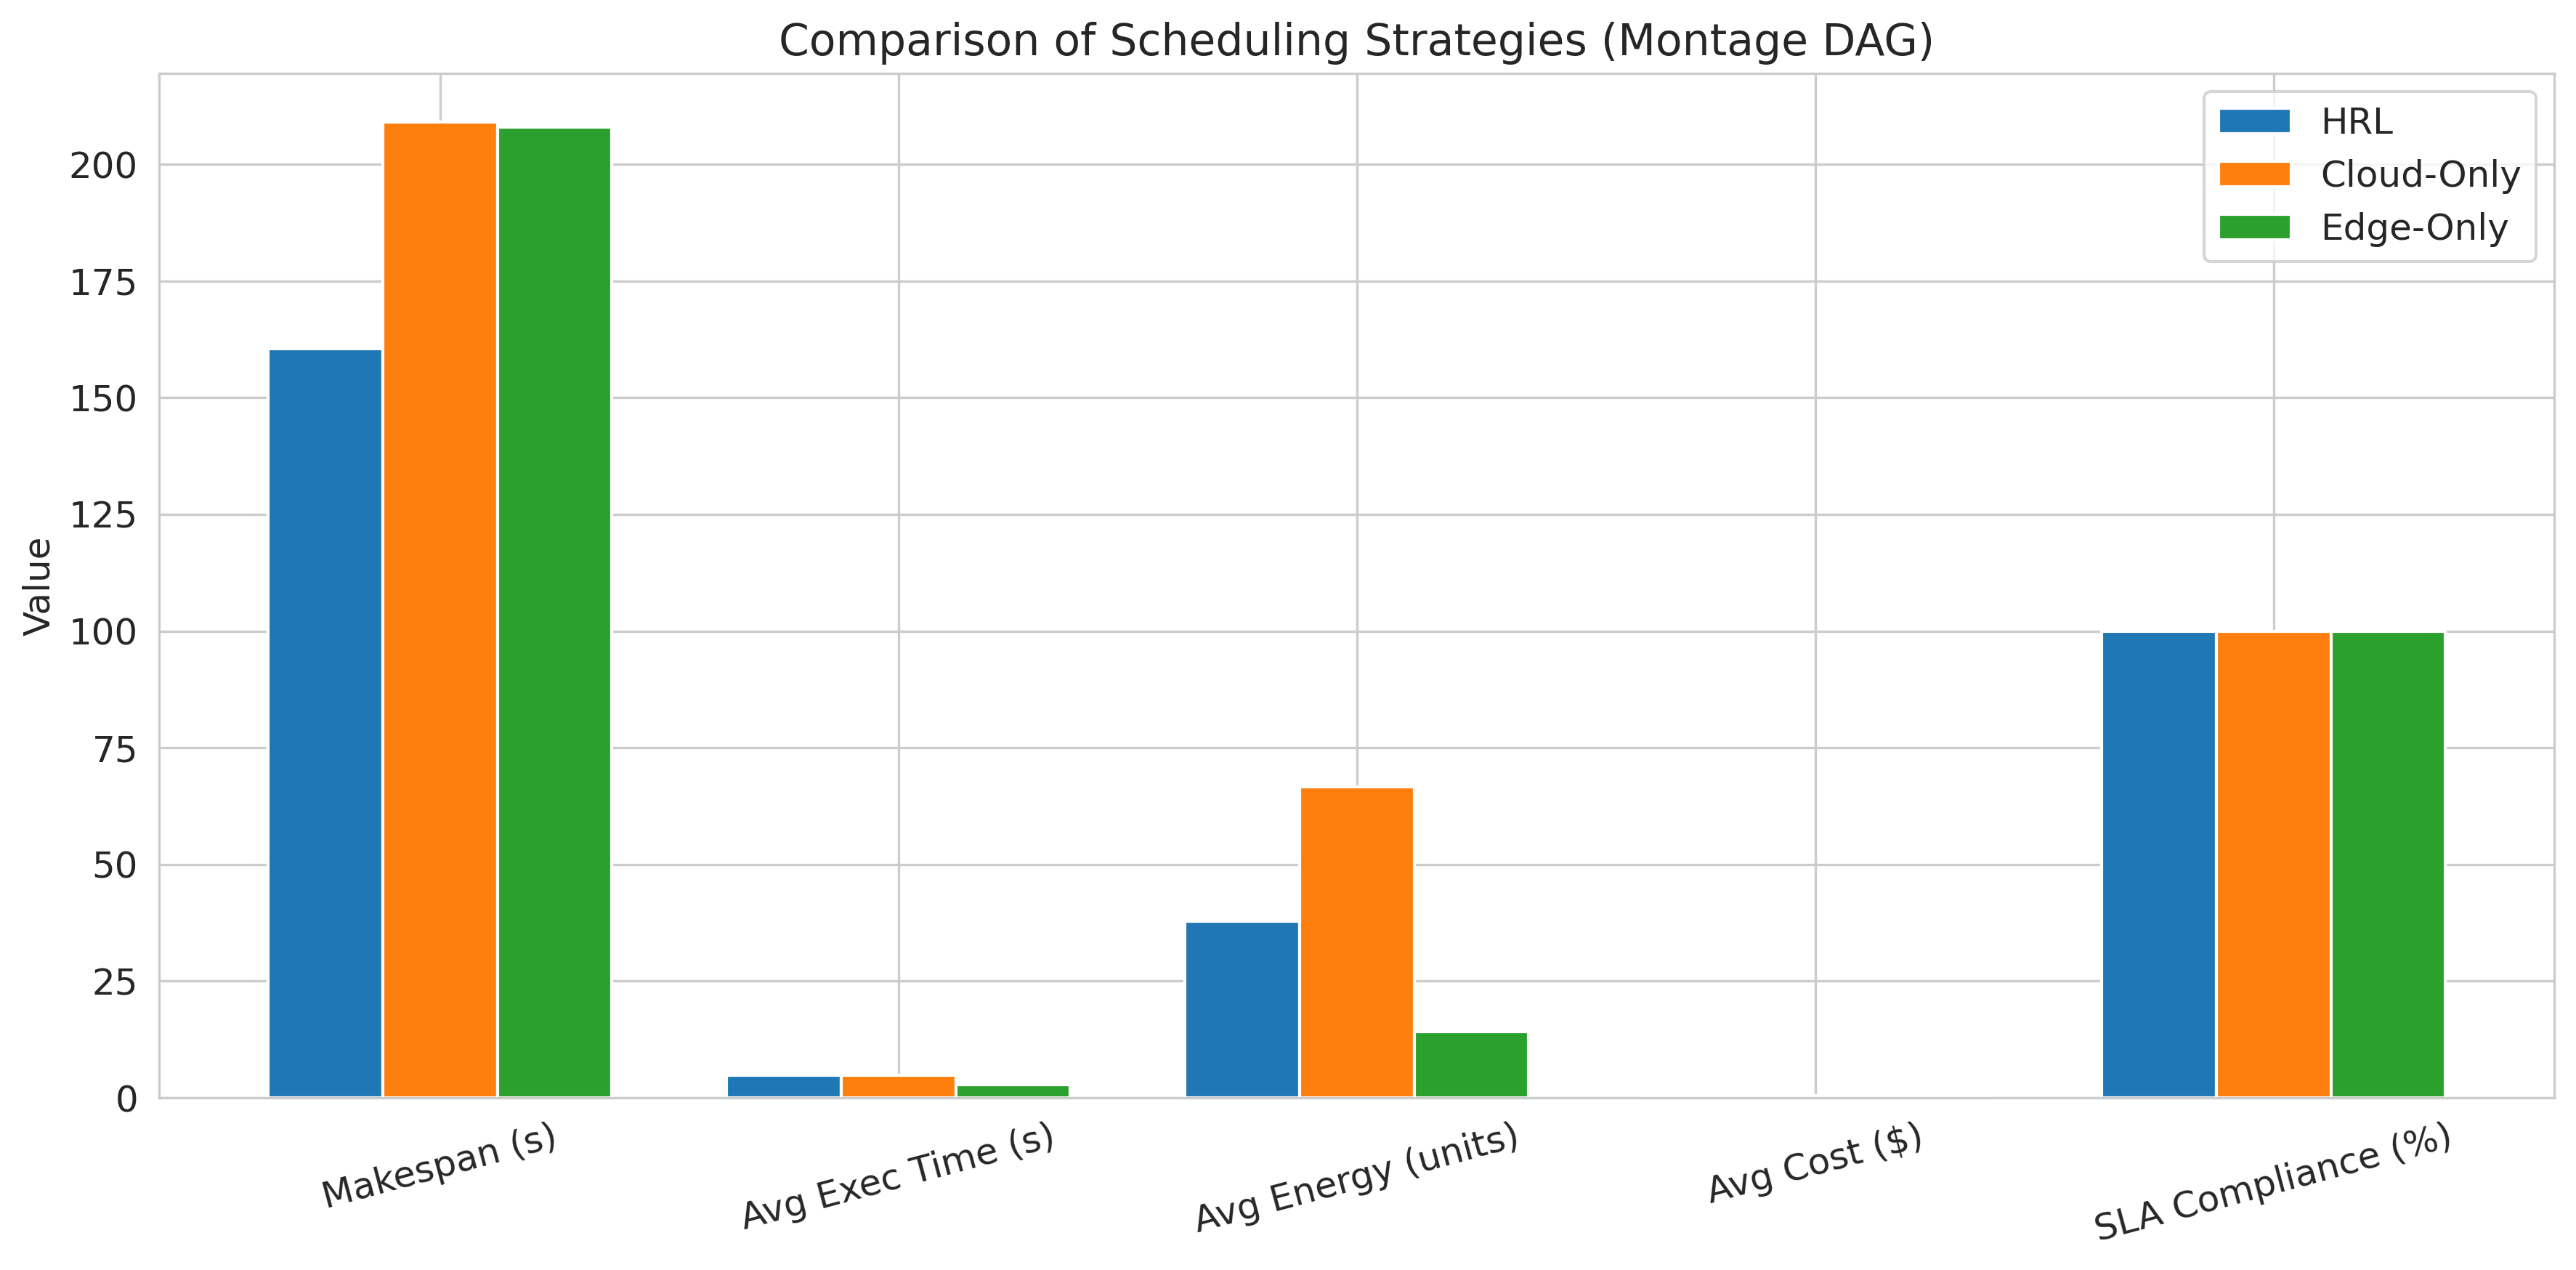

           Displaying placement_distribution.png                                 <ipython-input-7-4a45dddac728>:479

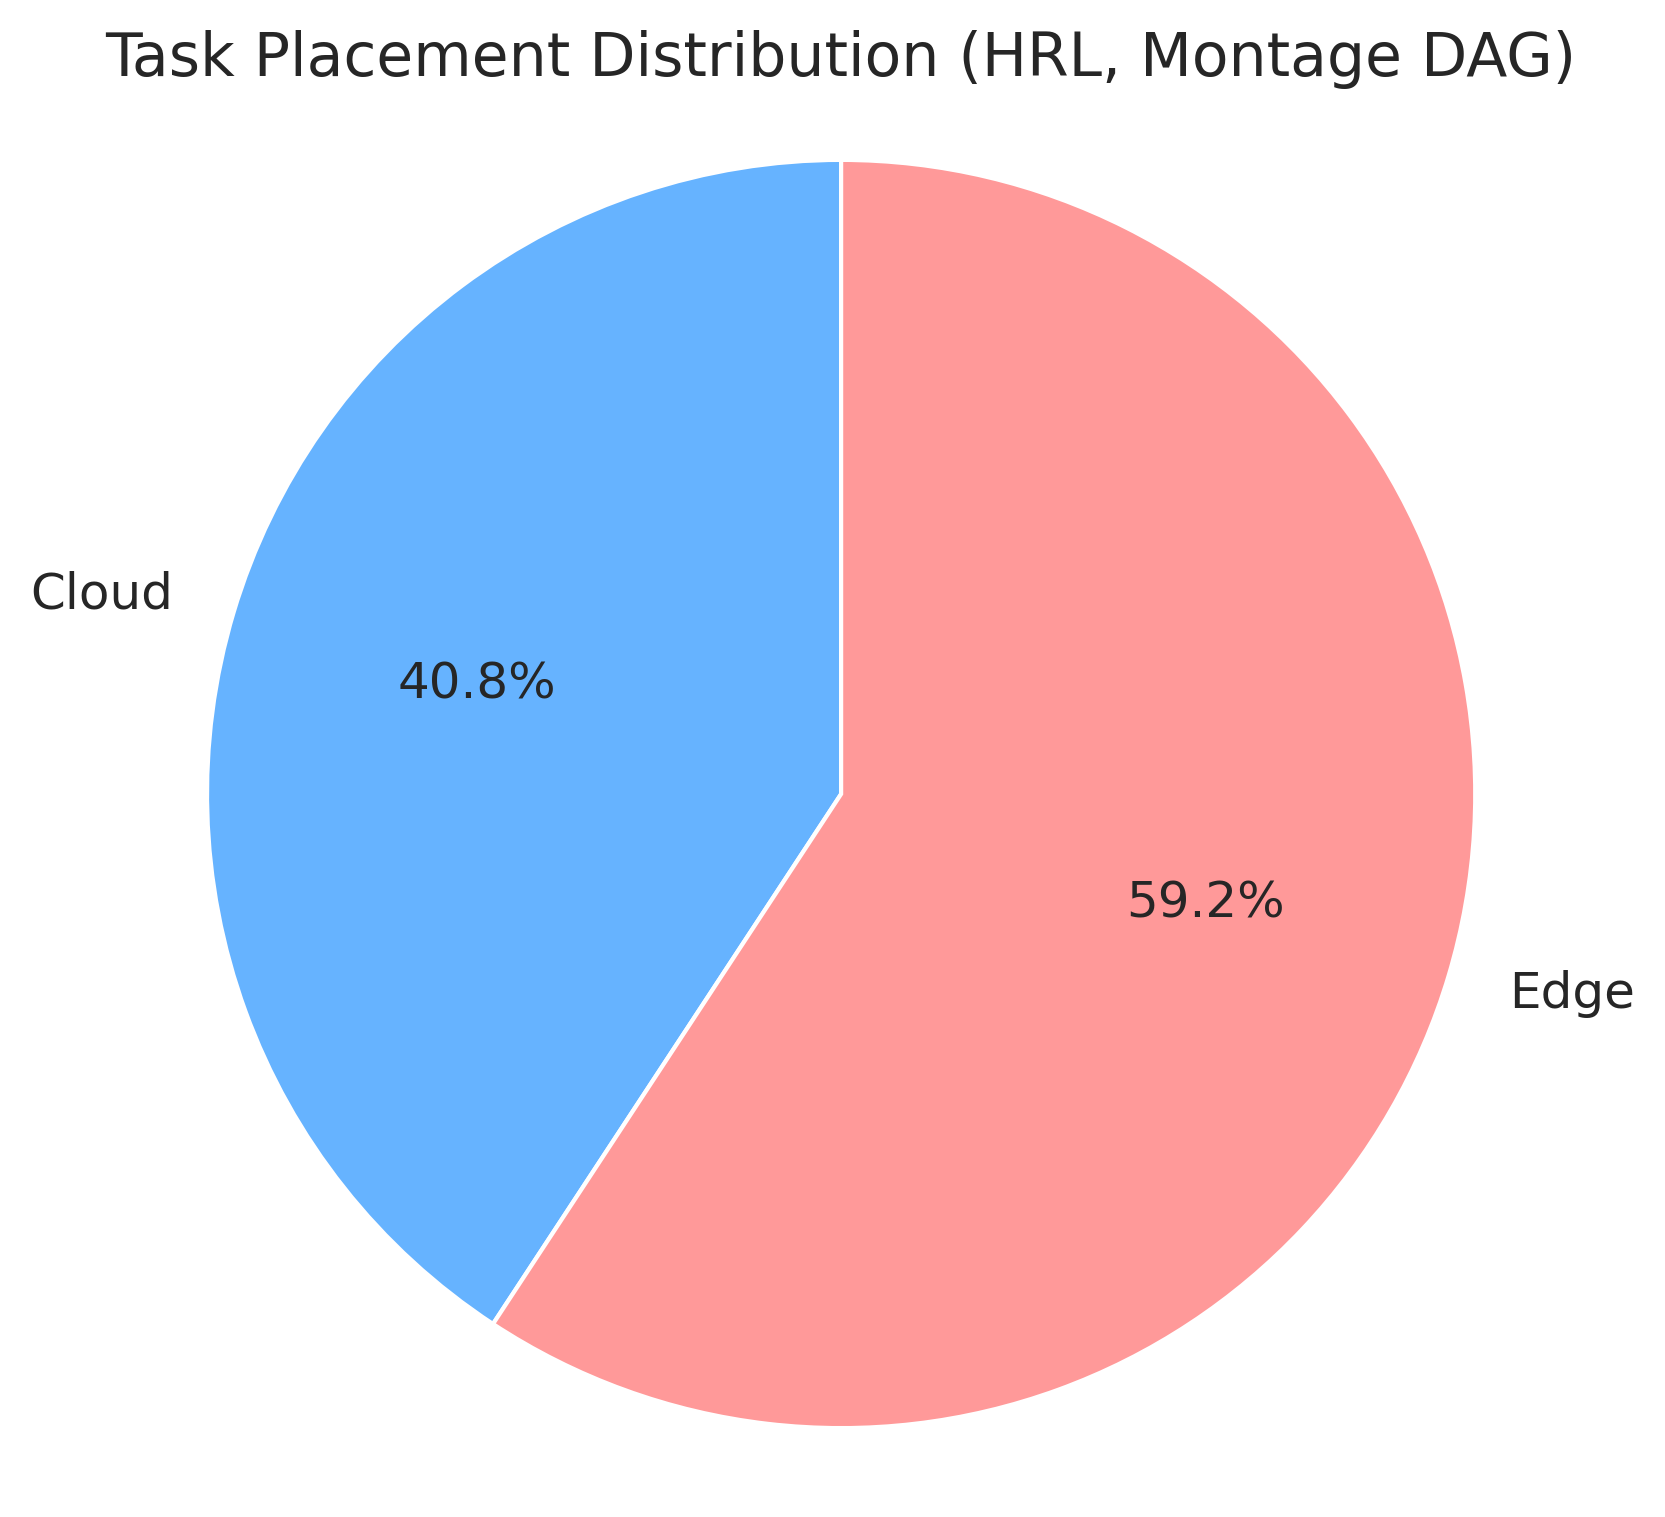

           Displaying load_balance.png                                           <ipython-input-7-4a45dddac728>:479

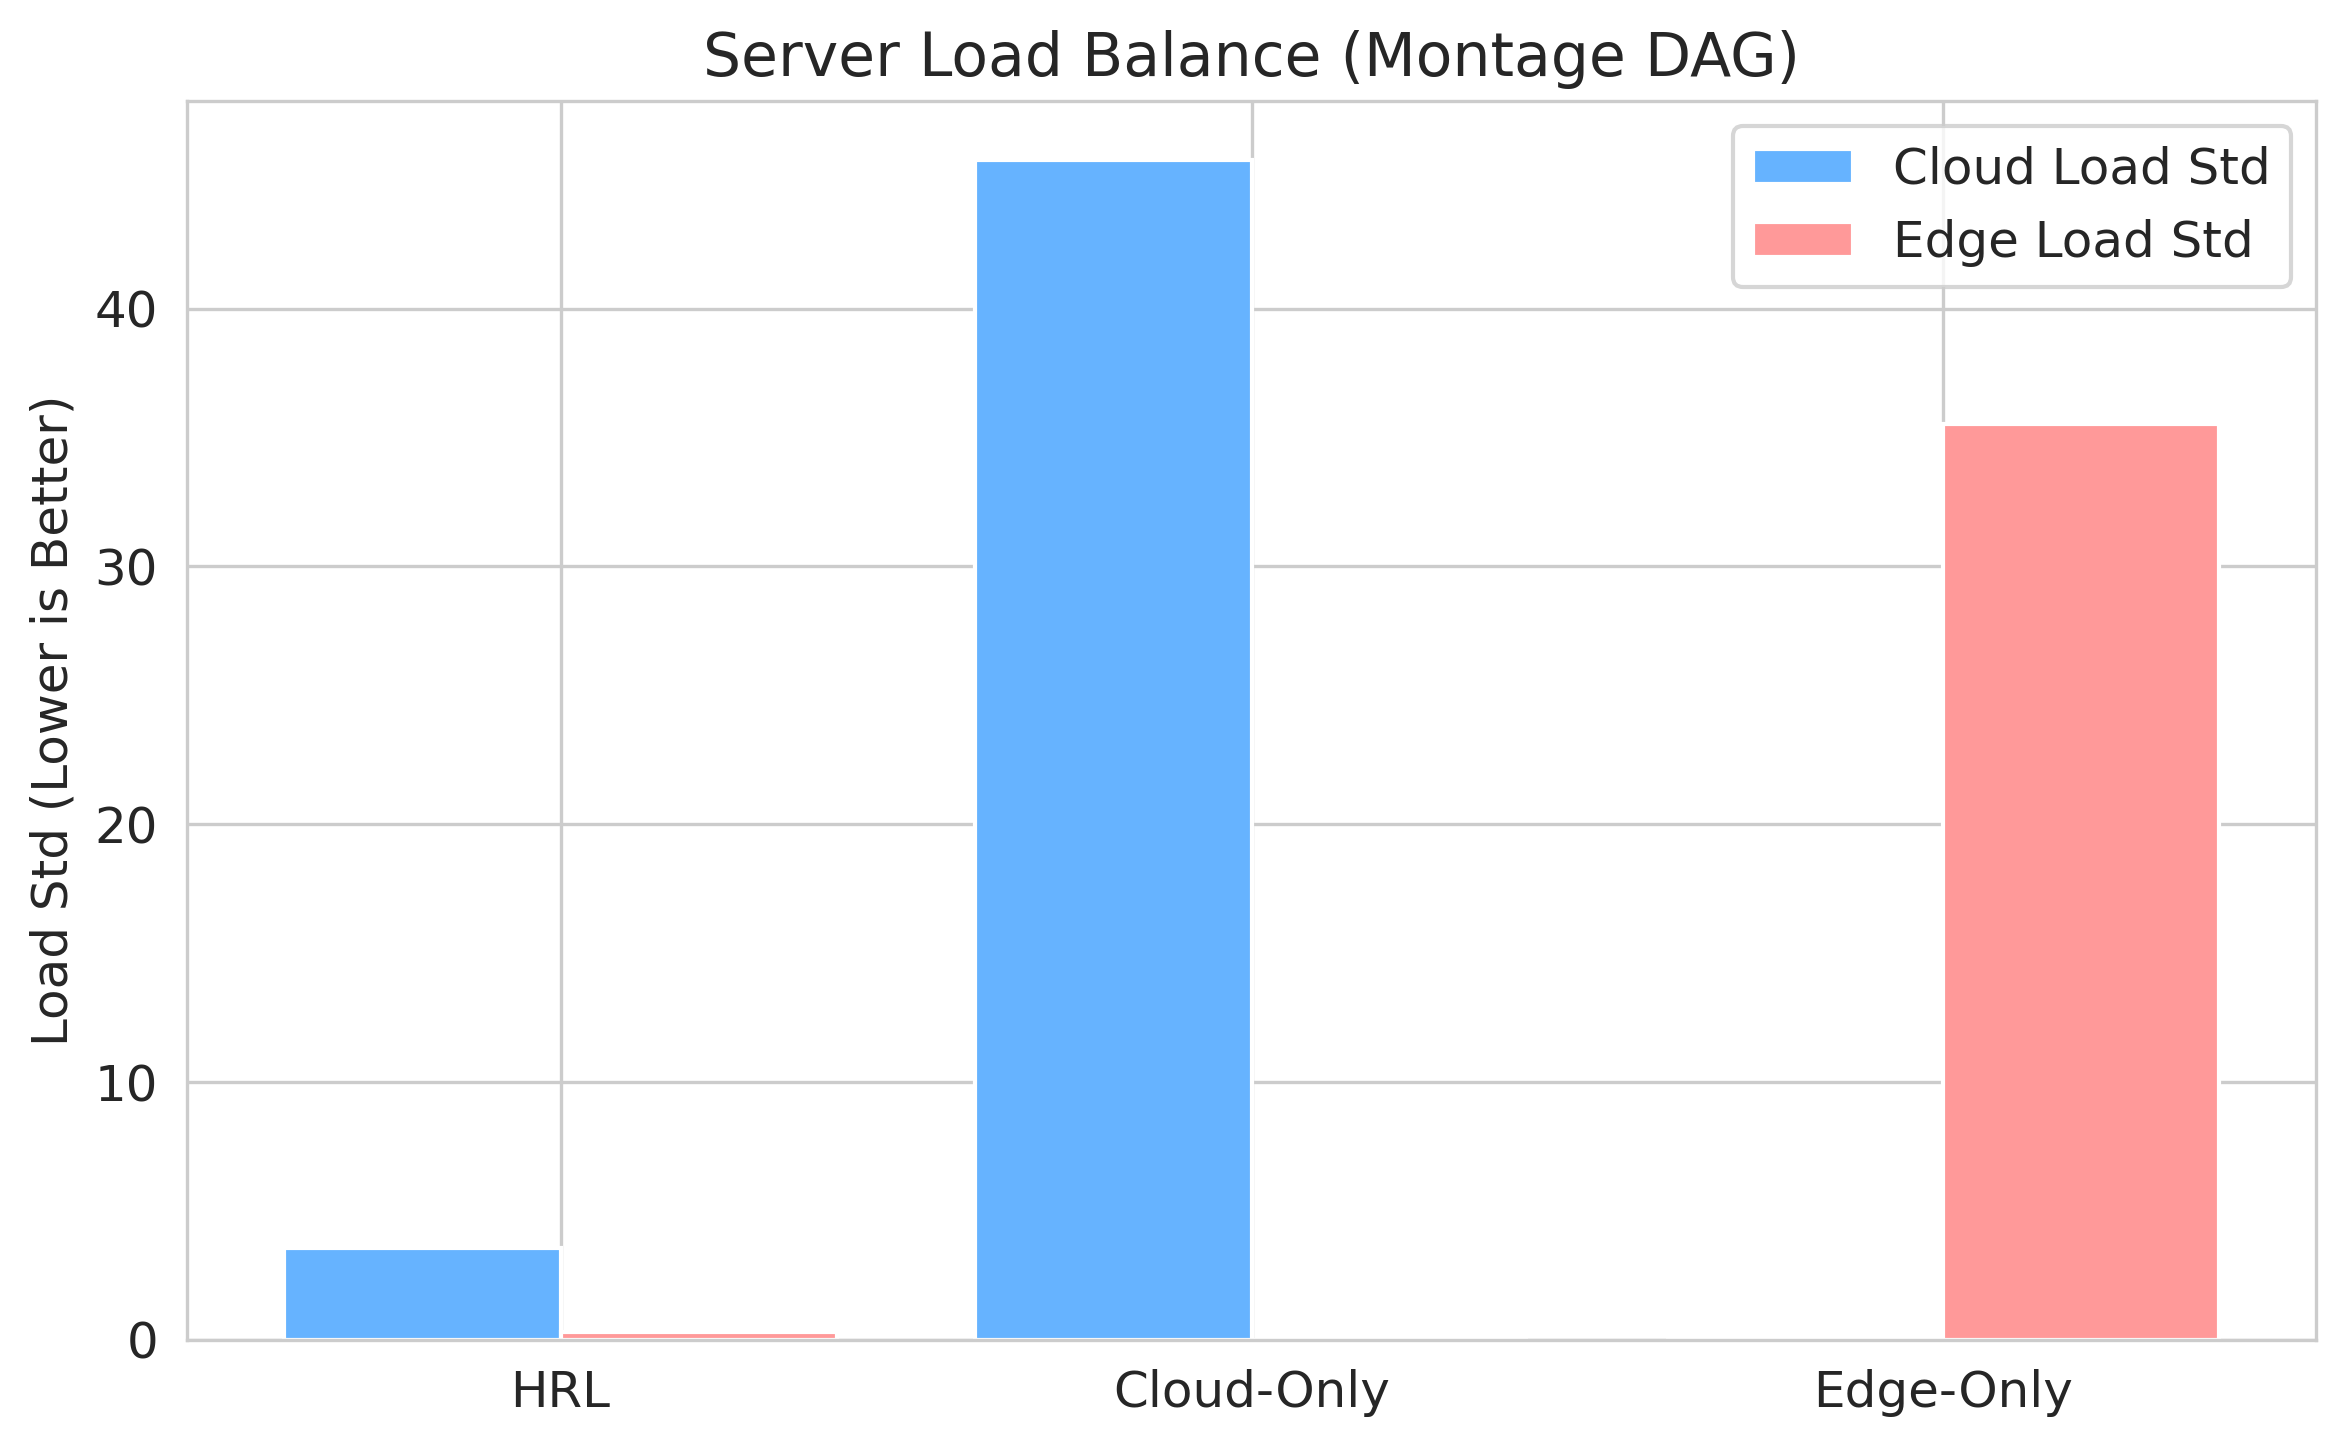

In [8]:
#training and testing of the scheduler and the models involved
if __name__ == "__main__":
    console = Console()
    # Suppress non-essential logs
    console.quiet = True
    for f in ["tier1_scheduler_new.zip", "tier2_scheduler_new.zip", "schedule.json"]:
        if os.path.exists(f):
            os.remove(f)
    # Train GNN on CyberShake
    trainer = GNNTrainer("balanced_cybershake_dag.json", "dag_embeddings_uncert.pth", embedding_dim=32)
    trainer.train(epochs=50)
    # Train HRL on CyberShake
    scheduler = WorkflowScheduler("balanced_cybershake_dag.json", "dag_embeddings_uncert.pth")
    scheduler.train_tier1(timesteps=20000)
    scheduler.train_tier2(timesteps=20000)
    # Validate on Montage
    scheduler.validate()
    scheduler.run_baselines()
    # Generate all results
    console.quiet = False
    scheduler.present_results()

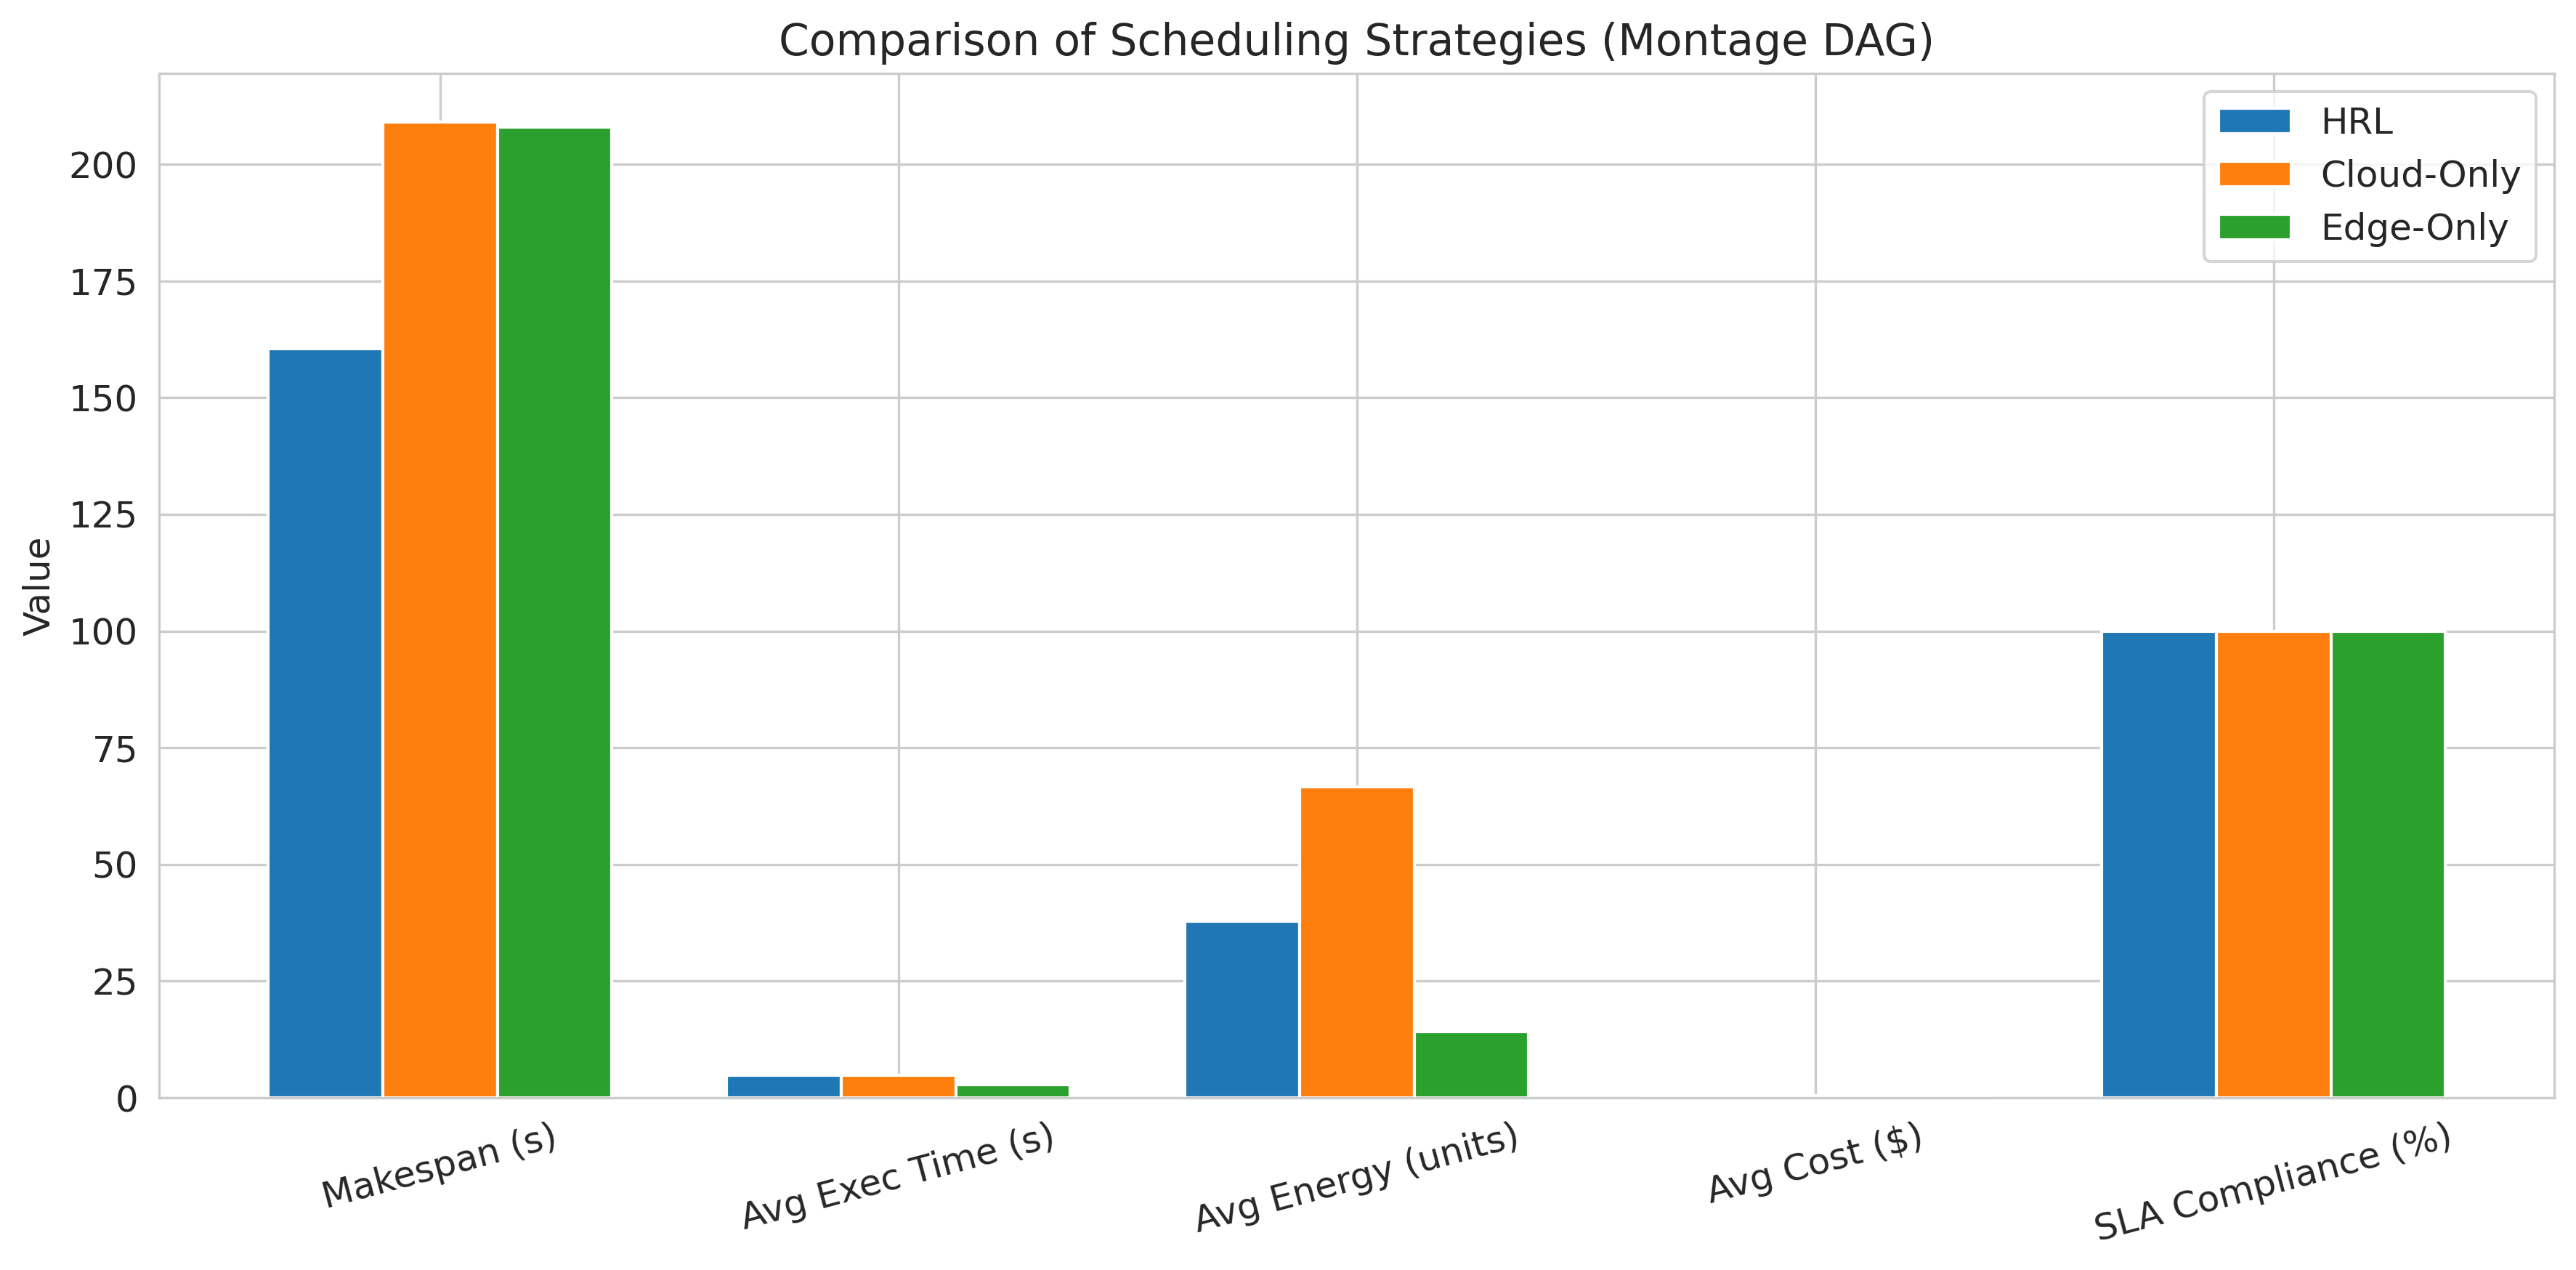

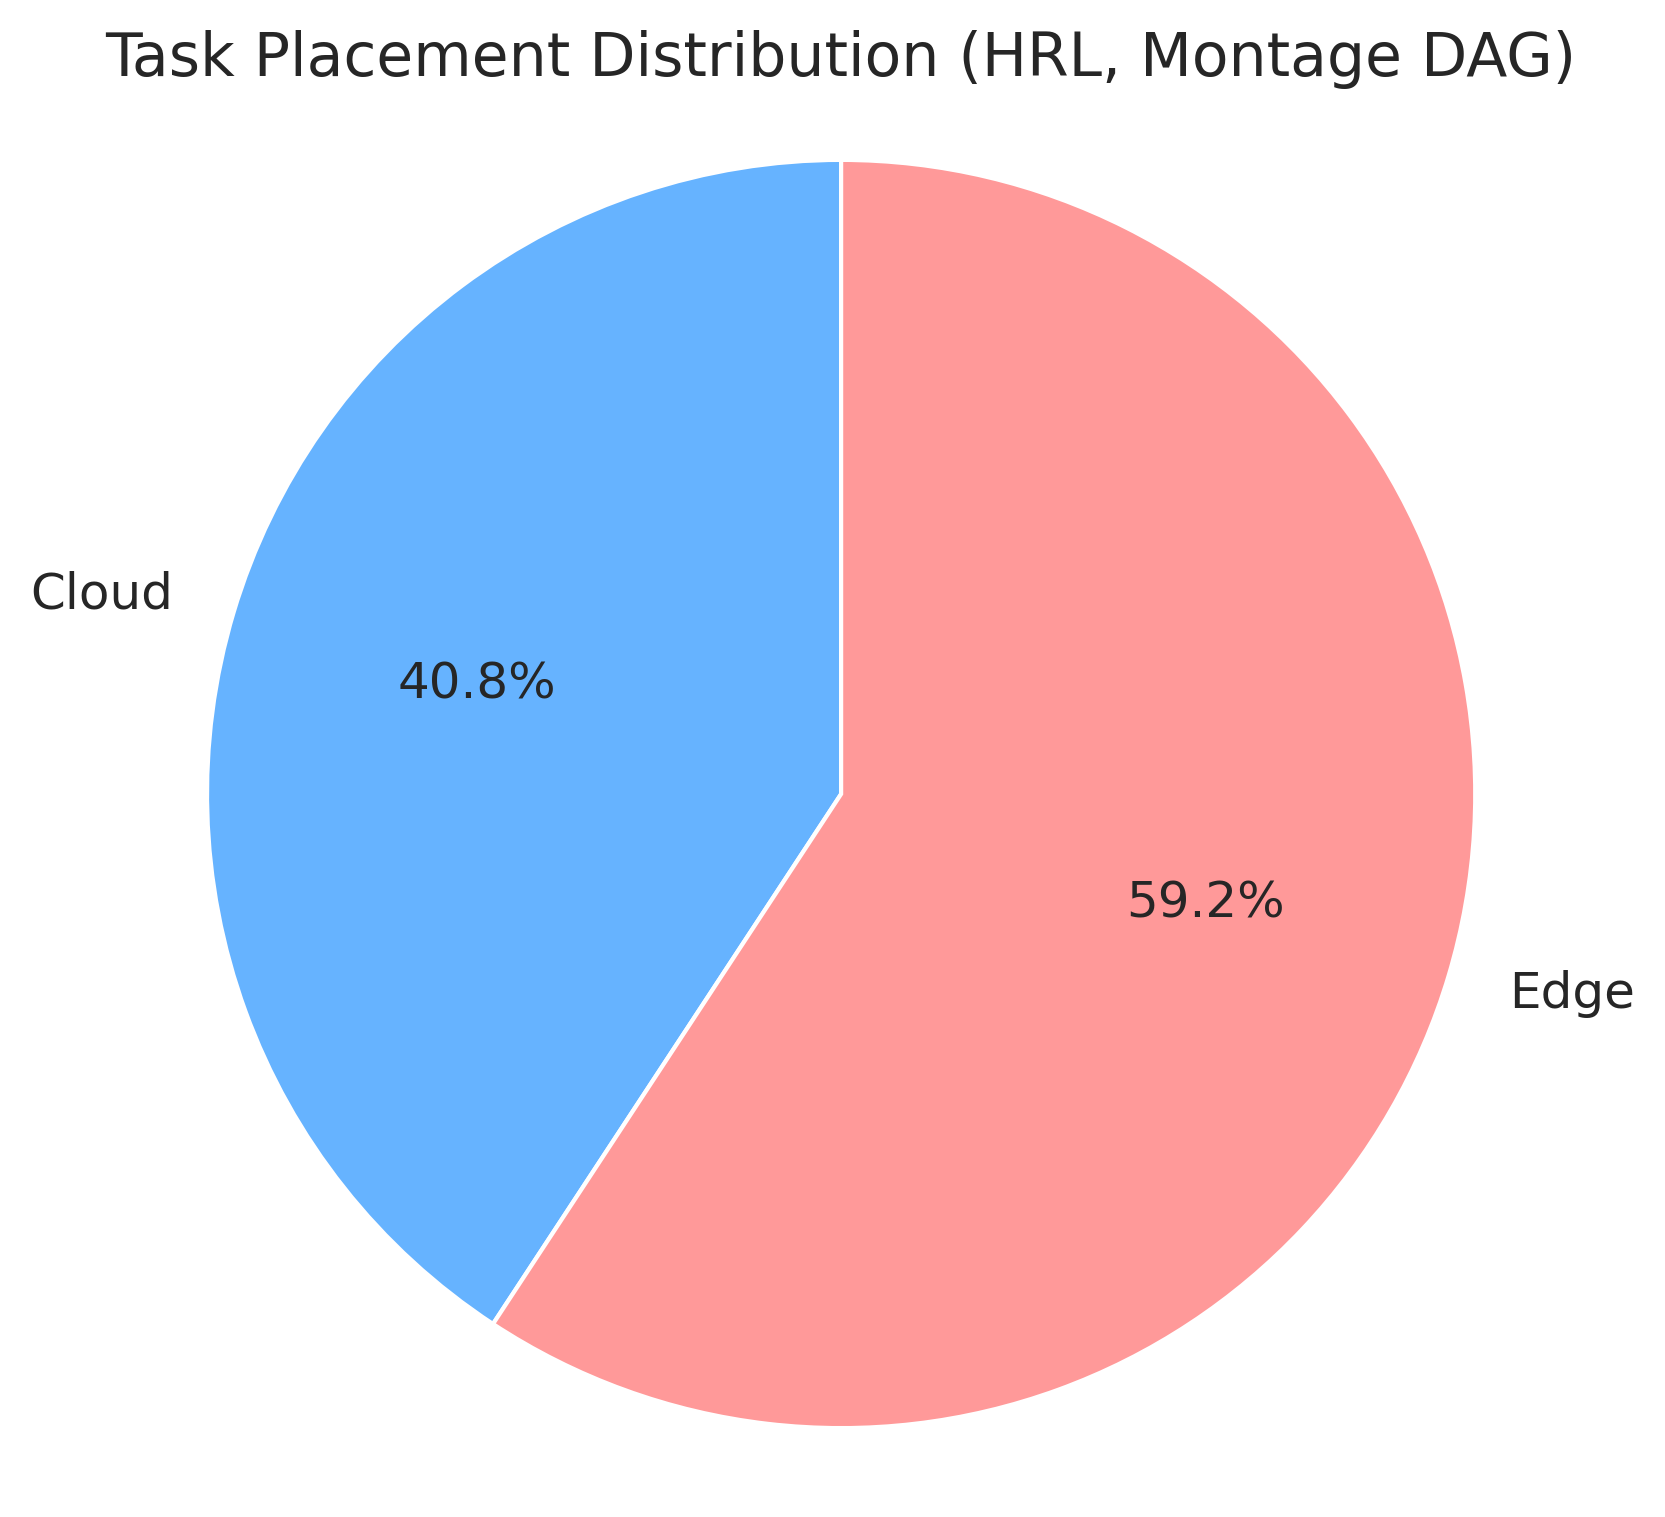

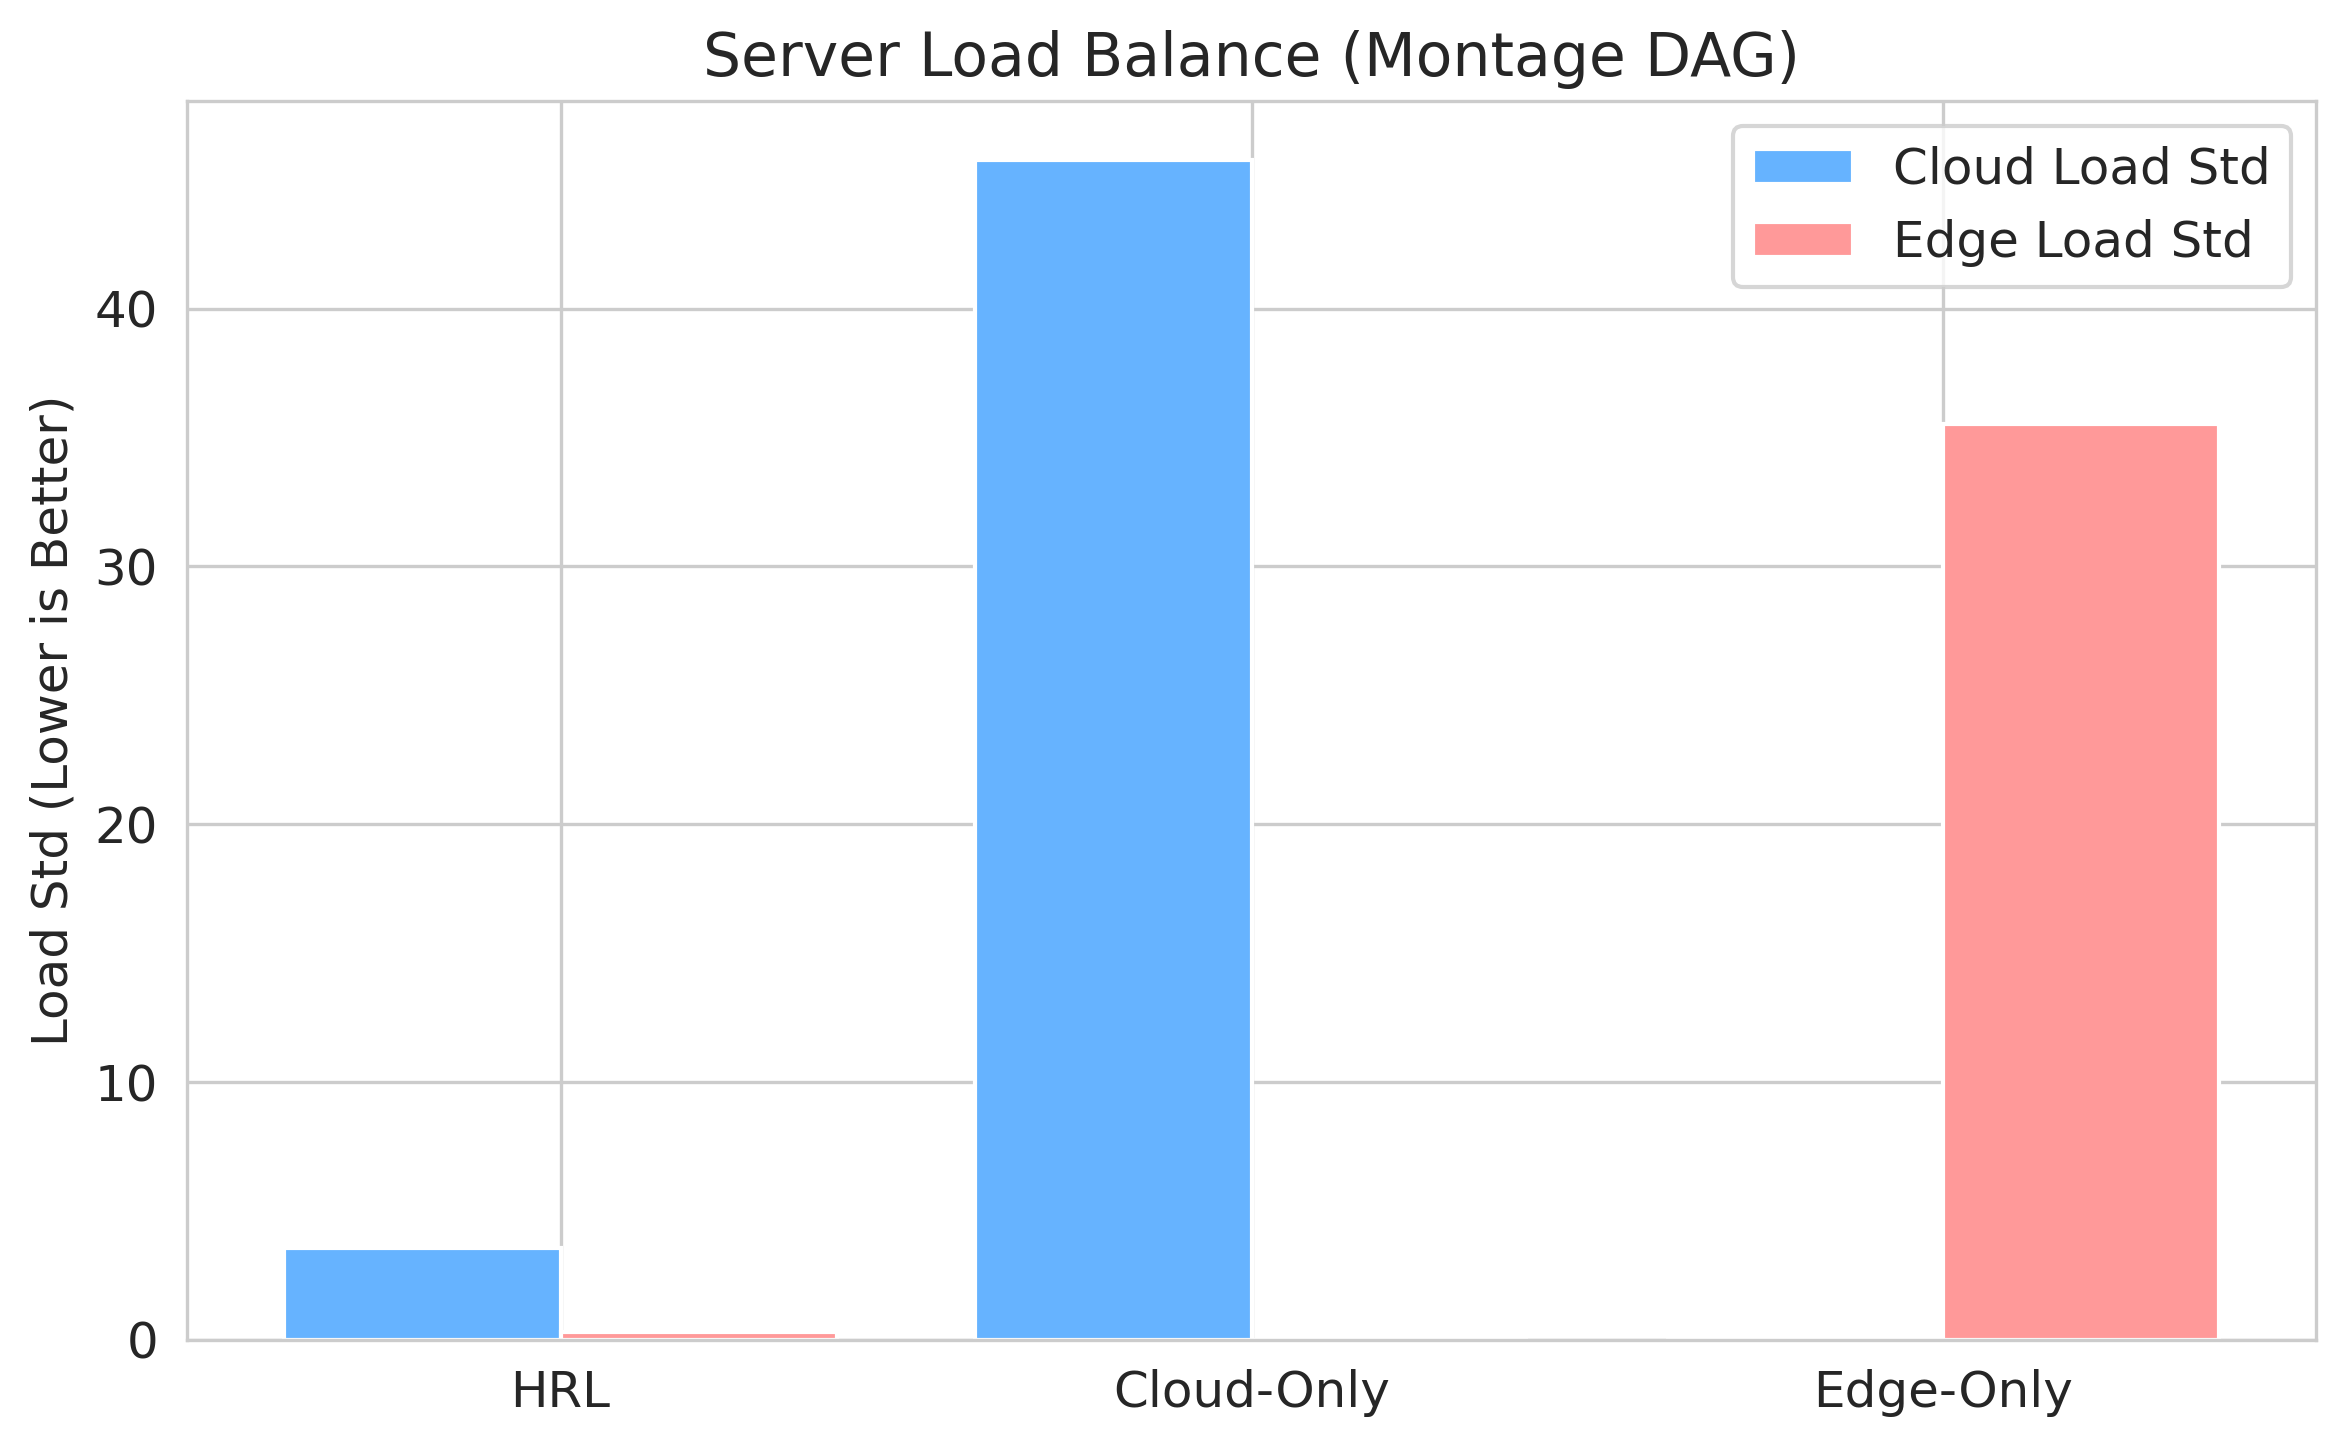

In [9]:
#showing the visualisations seperately
from IPython.display import Image, display
import os

def show_pngs(max_width=300):
    """Displays PNG images with a specified maximum width."""
    image_paths = [
        "metrics_comparison.png",
        "placement_distribution.png",
        "load_balance.png"
    ]
    for image_path in image_paths:
        if os.path.exists(image_path):
            display(Image(filename=image_path, width=max_width))
        else:
            print(f"Warning: Image file not found: {image_path}")
show_pngs(max_width=600)

DEFINING AND TESTING OTHER BASELINE MODELS

In [10]:
#Shortest Job First - SJF
import json
import networkx as nx
import numpy as np
import torch
import os
from rich.console import Console
from rich.table import Table

class SJFScheduler:
    def __init__(self, dag_file="balanced_montage_dag.json", embeddings_file="montage_embeddings.pth", max_nodes=1000):
        self.dag_file = dag_file
        self.embeddings_file = embeddings_file
        self.max_nodes = max_nodes
        self.console = Console()
        self.dag, self.embeddings, self.task_ids = self.load_dag_and_embeddings()
        self.task_queue = TaskQueue(self.dag, self.embeddings, self.task_ids)
        self.metrics = None

    def load_dag_and_embeddings(self):
        if not os.path.exists(self.dag_file):
            self.console.log(f"Error: DAG file {self.dag_file} not found")
            raise FileNotFoundError(f"DAG file {self.dag_file} not found")
        with open(self.dag_file, "r") as f:
            dag_json = json.load(f)
        dag = nx.node_link_graph(dag_json, edges="links")
        if len(dag.nodes) > self.max_nodes:
            nodes = list(dag.nodes)[:self.max_nodes]
            dag = dag.subgraph(nodes).copy()

        if not os.path.exists(self.embeddings_file):
            self.console.log(f"Warning: Embeddings file {self.embeddings_file} not found, using zeros")
            task_embeddings_dict = {tid: {"mean": np.zeros(32), "uncertainty": np.zeros(32)} for tid in dag.nodes()}
            torch.save({"task_embeddings": task_embeddings_dict}, self.embeddings_file)

        embeddings_data = torch.load(self.embeddings_file, map_location=torch.device('cpu'))
        task_embeddings_dict = embeddings_data["task_embeddings"]
        task_ids = list(dag.nodes())
        task_embeddings = np.array([
            task_embeddings_dict.get(tid, {"mean": np.zeros(32)}).get("mean", np.zeros(32)) for tid in task_ids
        ])
        return dag, task_embeddings, task_ids

    def schedule(self):
        self.task_queue.reset()
        total_exec_time = total_energy = total_cost = sla_compliance = tasks_started = 0
        queue_lengths = []
        cloud_tasks = 0
        max_steps = len(self.task_ids) * 10
        step = 0
        total_reward = 0

        while len(self.task_queue.completed) < len(self.task_ids) and step < max_steps:
            self.task_queue.update_running()
            queue_lengths.append(len(self.task_queue.get_ready_tasks()))
            ready_tasks = self.task_queue.get_ready_tasks()
            if not ready_tasks and not self.task_queue.running:
                future_arrivals = [t["arrival_time"] for t in self.task_queue.tasks.values()
                                   if t["arrival_time"] > self.task_queue.current_time and
                                   t["dependencies"].issubset(self.task_queue.completed)]
                if future_arrivals:
                    self.task_queue.current_time = min(future_arrivals)
                    continue
                self.console.log(f"Validation stopped: {len(self.task_ids) - len(self.task_queue.completed)} tasks incomplete")
                break

            ready_tasks = sorted(ready_tasks, key=lambda tid: self.task_queue.tasks[tid]["exec_time"])
            self.task_queue.update_conditions()

            for tid in ready_tasks[:1]:
                base_time = self.task_queue.tasks[tid]["exec_time"]
                best_exec_time = float('inf')
                best_placement = None
                best_server = None

                for placement in ["cloud", "edge"]:
                    if placement == "edge" and np.mean(self.task_queue.edge_battery) < 20:
                        continue
                    for server in range(len(self.task_queue.server_loads[placement])):
                        load_factor = min(self.task_queue.server_loads[placement][server] / (3.0 if placement == "cloud" else 2.0), 0.3)
                        exec_time = base_time * (1 + load_factor * 0.3 + min(self.task_queue.network_latency * 0.3, 0.5))
                        exec_time = min(exec_time, 5.0)
                        if exec_time < best_exec_time:
                            best_exec_time = exec_time
                            best_placement = placement
                            best_server = server

                if best_placement is None:
                    best_placement = "cloud"
                    best_server = int(np.argmin(self.task_queue.server_loads["cloud"]))
                    load_factor = min(self.task_queue.server_loads["cloud"][best_server] / 3.0, 0.3)
                    best_exec_time = base_time * (1 + load_factor * 0.3 + min(self.task_queue.network_latency * 0.3, 0.5))
                    best_exec_time = min(best_exec_time, 5.0)

                base_power = (self.task_queue.cloud_base_power[best_server] if best_placement == "cloud"
                              else self.task_queue.edge_base_power[best_server])
                energy = (base_power + load_factor * 5) * best_exec_time
                cost = best_exec_time * (0.10 if best_placement == "cloud" else 0.05)
                sla_met = 1 if best_exec_time <= base_time * 1.5 else 0

                self.task_queue.start_task(tid, best_placement, best_server, best_exec_time)
                tasks_started += 1
                total_exec_time += best_exec_time
                total_energy += energy
                total_cost += cost
                sla_compliance += sla_met
                if best_placement == "cloud":
                    cloud_tasks += 1
                total_reward += (30.0 * sla_met - 0.1 * (best_exec_time / 5.0) - 0.05 * (energy / 5.0))

            step += 1

        self.save_schedule()
        completed_count = len(self.task_queue.completed)
        throughput = completed_count / self.task_queue.current_time if self.task_queue.current_time > 0 else 0
        avg_queue_length = np.mean(queue_lengths) if queue_lengths else 0
        cloud_load_balance = np.std(self.task_queue.server_loads["cloud"])
        edge_load_balance = np.std(self.task_queue.server_loads["edge"])
        avg_edge_battery = np.mean(self.task_queue.edge_battery)
        avg_reward = total_reward / step if step > 0 else 0
        cloud_ratio = cloud_tasks / tasks_started if tasks_started > 0 else 0
        avg_exec_time = total_exec_time / tasks_started if tasks_started else 0
        avg_energy = total_energy / tasks_started if tasks_started else 0
        avg_cost = total_cost / tasks_started if tasks_started else 0
        sla_rate = sla_compliance / tasks_started if tasks_started > 0 else 0

        self.metrics = {
            "makespan": self.task_queue.current_time,
            "avg_exec_time": avg_exec_time,
            "avg_energy": avg_energy,
            "avg_cost": avg_cost,
            "sla_rate": sla_rate,
            "cloud_ratio": cloud_ratio,
            "throughput": throughput,
            "avg_queue_length": avg_queue_length,
            "cloud_load_balance": cloud_load_balance,
            "edge_load_balance": edge_load_balance,
            "avg_edge_battery": avg_edge_battery,
            "avg_reward": avg_reward,
            "completed_count": completed_count,
            "total_tasks": len(self.task_ids)
        }
        self.console.log(f"SJF Metrics: Makespan={self.metrics['makespan']:.2f}s, SLA={self.metrics['sla_rate']:.2%}")
        return self.metrics

    def save_schedule(self):
        schedule = {
            tid: {
                "placement": task["history"][-1]["placement"] if task["history"] else "N/A",
                "server": int(task["history"][-1]["server"]) if task["history"] else -1,
                "exec_time": float(task["history"][-1]["exec_time"]) if task["history"] else 0.0
            } for tid, task in self.task_queue.tasks.items() if task["history"]
        }
        filename = "schedule_sjf.json"
        with open(filename, "w") as f:
            json.dump(schedule, f)
        self.console.log(f"Saved SJF schedule with {len(schedule)} tasks to {filename}")

In [11]:
#Heterogeneous Earliest Finish Time - HEFT
class HEFTScheduler:
    def __init__(self, dag_file="balanced_montage_dag.json", embeddings_file="montage_embeddings.pth", max_nodes=1000):
        self.dag_file = dag_file
        self.embeddings_file = embeddings_file
        self.max_nodes = max_nodes
        self.console = Console()
        self.dag, self.embeddings, self.task_ids = self.load_dag_and_embeddings()
        self.task_queue = TaskQueue(self.dag, self.embeddings, self.task_ids)
        self.metrics = None

    def load_dag_and_embeddings(self):
        if not os.path.exists(self.dag_file):
            self.console.log(f"Error: DAG file {self.dag_file} not found")
            raise FileNotFoundError(f"DAG file {self.dag_file} not found")
        with open(self.dag_file, "r") as f:
            dag_json = json.load(f)
        dag = nx.node_link_graph(dag_json, edges="links")
        if len(dag.nodes) > self.max_nodes:
            nodes = list(dag.nodes)[:self.max_nodes]
            dag = dag.subgraph(nodes).copy()

        if not os.path.exists(self.embeddings_file):
            self.console.log(f"Warning: Embeddings file {self.embeddings_file} not found, using zeros")
            task_embeddings_dict = {tid: {"mean": np.zeros(32), "uncertainty": np.zeros(32)} for tid in dag.nodes()}
            torch.save({"task_embeddings": task_embeddings_dict}, self.embeddings_file)

        embeddings_data = torch.load(self.embeddings_file, map_location=torch.device('cpu'))
        task_embeddings_dict = embeddings_data["task_embeddings"]
        task_ids = list(dag.nodes())
        task_embeddings = np.array([
            task_embeddings_dict.get(tid, {"mean": np.zeros(32)}).get("mean", np.zeros(32)) for tid in task_ids
        ])
        return dag, task_embeddings, task_ids

    def compute_ranks(self):
        ranks = {}
        exit_nodes = [n for n in self.dag.nodes if self.dag.out_degree(n) == 0]

        def avg_exec_time(tid):
            return self.dag.nodes[tid].get("execution_time", 1.0)

        def avg_comm_time(src, dst):
            return self.dag.edges.get((src, dst), {}).get("T_comm", 0.1)

        def compute_rank(tid):
            if tid in ranks:
                return ranks[tid]
            if self.dag.out_degree(tid) == 0:
                ranks[tid] = avg_exec_time(tid)
                return ranks[tid]
            max_successor = 0
            for succ in self.dag.successors(tid):
                succ_rank = compute_rank(succ)
                comm_cost = avg_comm_time(tid, succ)
                max_successor = max(max_successor, comm_cost + succ_rank)
            ranks[tid] = avg_exec_time(tid) + max_successor
            return ranks[tid]

        for tid in self.task_ids:
            compute_rank(tid)
        return sorted(self.task_ids, key=lambda tid: ranks[tid], reverse=True)

    def schedule(self):
        self.task_queue.reset()
        total_exec_time = total_energy = total_cost = sla_compliance = tasks_started = 0
        queue_lengths = []
        cloud_tasks = 0
        max_steps = len(self.task_ids) * 10
        step = 0
        total_reward = 0
        task_order = self.compute_ranks()
        scheduled_tasks = set()

        while len(self.task_queue.completed) < len(self.task_ids) and step < max_steps:
            self.task_queue.update_running()
            queue_lengths.append(len(self.task_queue.get_ready_tasks()))
            ready_tasks = self.task_queue.get_ready_tasks()
            if not ready_tasks and not self.task_queue.running:
                future_arrivals = [t["arrival_time"] for t in self.task_queue.tasks.values()
                                   if t["arrival_time"] > self.task_queue.current_time and
                                   t["dependencies"].issubset(self.task_queue.completed)]
                if future_arrivals:
                    self.task_queue.current_time = min(future_arrivals)
                    continue
                self.console.log(f"Validation stopped: {len(self.task_ids) - len(self.task_queue.completed)} tasks incomplete")
                break

            self.task_queue.update_conditions()
            ready_ranks = [(tid, task_order.index(tid)) for tid in ready_tasks if tid not in scheduled_tasks]
            if not ready_ranks:
                self.task_queue.current_time += 0.5
                step += 1
                continue
            tid = min(ready_ranks, key=lambda x: x[1])[0]
            scheduled_tasks.add(tid)

            base_time = self.task_queue.tasks[tid]["exec_time"]
            earliest_finish = float('inf')
            best_placement = None
            best_server = None
            start_time = max([self.task_queue.current_time] +
                             [self.task_queue.tasks[dep]["history"][-1]["timestamp"] +
                              self.dag.edges.get((dep, tid), {}).get("T_comm", 0.1)
                              for dep in self.task_queue.tasks[tid]["dependencies"]
                              if self.task_queue.tasks[dep]["history"]])

            for placement in ["cloud", "edge"]:
                if placement == "edge" and np.mean(self.task_queue.edge_battery) < 20:
                    continue
                for server in range(len(self.task_queue.server_loads[placement])):
                    load_factor = min(self.task_queue.server_loads[placement][server] / (3.0 if placement == "cloud" else 2.0), 0.3)
                    exec_time = base_time * (1 + load_factor * 0.3 + min(self.task_queue.network_latency * 0.3, 0.5))
                    exec_time = min(exec_time, 5.0)
                    finish_time = start_time + exec_time
                    if finish_time < earliest_finish:
                        earliest_finish = finish_time
                        best_placement = placement
                        best_server = server
                        best_exec_time = exec_time

            if best_placement is None:
                best_placement = "cloud"
                best_server = int(np.argmin(self.task_queue.server_loads["cloud"]))
                load_factor = min(self.task_queue.server_loads["cloud"][best_server] / 3.0, 0.3)
                best_exec_time = base_time * (1 + load_factor * 0.3 + min(self.task_queue.network_latency * 0.3, 0.5))
                best_exec_time = min(best_exec_time, 5.0)

            base_power = (self.task_queue.cloud_base_power[best_server] if best_placement == "cloud"
                          else self.task_queue.edge_base_power[best_server])
            energy = (base_power + load_factor * 5) * best_exec_time
            cost = best_exec_time * (0.10 if best_placement == "cloud" else 0.05)
            sla_met = 1 if best_exec_time <= base_time * 1.5 else 0

            self.task_queue.start_task(tid, best_placement, best_server, best_exec_time)
            tasks_started += 1
            total_exec_time += best_exec_time
            total_energy += energy
            total_cost += cost
            sla_compliance += sla_met
            if best_placement == "cloud":
                cloud_tasks += 1
            total_reward += (30.0 * sla_met - 0.1 * (best_exec_time / 5.0) - 0.05 * (energy / 5.0))

            step += 1

        self.save_schedule()
        completed_count = len(self.task_queue.completed)
        throughput = completed_count / self.task_queue.current_time if self.task_queue.current_time > 0 else 0
        avg_queue_length = np.mean(queue_lengths) if queue_lengths else 0
        cloud_load_balance = np.std(self.task_queue.server_loads["cloud"])
        edge_load_balance = np.std(self.task_queue.server_loads["edge"])
        avg_edge_battery = np.mean(self.task_queue.edge_battery)
        avg_reward = total_reward / step if step > 0 else 0
        cloud_ratio = cloud_tasks / tasks_started if tasks_started > 0 else 0
        avg_exec_time = total_exec_time / tasks_started if tasks_started else 0
        avg_energy = total_energy / tasks_started if tasks_started else 0
        avg_cost = total_cost / tasks_started if tasks_started else 0
        sla_rate = sla_compliance / tasks_started if tasks_started > 0 else 0

        self.metrics = {
            "makespan": self.task_queue.current_time,
            "avg_exec_time": avg_exec_time,
            "avg_energy": avg_energy,
            "avg_cost": avg_cost,
            "sla_rate": sla_rate,
            "cloud_ratio": cloud_ratio,
            "throughput": throughput,
            "avg_queue_length": avg_queue_length,
            "cloud_load_balance": cloud_load_balance,
            "edge_load_balance": edge_load_balance,
            "avg_edge_battery": avg_edge_battery,
            "avg_reward": avg_reward,
            "completed_count": completed_count,
            "total_tasks": len(self.task_ids)
        }
        self.console.log(f"HEFT Metrics: Makespan={self.metrics['makespan']:.2f}s, SLA={self.metrics['sla_rate']:.2%}")
        return self.metrics

    def save_schedule(self):
        schedule = {
            tid: {
                "placement": task["history"][-1]["placement"] if task["history"] else "N/A",
                "server": int(task["history"][-1]["server"]) if task["history"] else -1,
                "exec_time": float(task["history"][-1]["exec_time"]) if task["history"] else 0.0
            } for tid, task in self.task_queue.tasks.items() if task["history"]
        }
        filename = "schedule_heft.json"
        with open(filename, "w") as f:
            json.dump(schedule, f)
        self.console.log(f"Saved HEFT schedule with {len(schedule)} tasks to {filename}")

In [12]:
#Critical Path Scheduler - CPM
class CriticalPathScheduler:
    def __init__(self, dag_file="balanced_montage_dag.json", embeddings_file="montage_embeddings.pth", max_nodes=1000):
        self.dag_file = dag_file
        self.embeddings_file = embeddings_file
        self.max_nodes = max_nodes
        self.console = Console()
        self.dag, self.embeddings, self.task_ids = self.load_dag_and_embeddings()
        self.task_queue = TaskQueue(self.dag, self.embeddings, self.task_ids)
        self.metrics = None
        self.critical_path = self.compute_critical_path()

    def load_dag_and_embeddings(self):
        if not os.path.exists(self.dag_file):
            self.console.log(f"Error: DAG file {self.dag_file} not found")
            raise FileNotFoundError(f"DAG file {self.dag_file} not found")
        with open(self.dag_file, "r") as f:
            dag_json = json.load(f)
        dag = nx.node_link_graph(dag_json, edges="links")
        if len(dag.nodes) > self.max_nodes:
            nodes = list(dag.nodes)[:self.max_nodes]
            dag = dag.subgraph(nodes).copy()

        if not os.path.exists(self.embeddings_file):
            self.console.log(f"Warning: Embeddings file {self.embeddings_file} not found, using zeros")
            task_embeddings_dict = {tid: {"mean": np.zeros(32), "uncertainty": np.zeros(32)} for tid in dag.nodes()}
            torch.save({"task_embeddings": task_embeddings_dict}, self.embeddings_file)

        embeddings_data = torch.load(self.embeddings_file, map_location=torch.device('cpu'))
        task_embeddings_dict = embeddings_data["task_embeddings"]
        task_ids = list(dag.nodes())
        task_embeddings = np.array([
            task_embeddings_dict.get(tid, {"mean": np.zeros(32)}).get("mean", np.zeros(32)) for tid in task_ids
        ])
        return dag, task_embeddings, task_ids

    def compute_critical_path(self):
        longest_path = []
        max_length = 0
        exit_nodes = [n for n in self.dag.nodes if self.dag.out_degree(n) == 0]
        entry_nodes = [n for n in self.dag.nodes if self.dag.in_degree(n) == 0]

        def path_length(path):
            length = sum(self.dag.nodes[n].get("execution_time", 1.0) for n in path)
            for i in range(len(path) - 1):
                length += self.dag.edges.get((path[i], path[i+1]), {}).get("T_comm", 0.1)
            return length

        def find_paths(current, target, path, all_paths):
            if current == target:
                all_paths.append(path[:])
                return
            for succ in self.dag.successors(current):
                path.append(succ)
                find_paths(succ, target, path, all_paths)
                path.pop()

        critical_path = []
        for entry in entry_nodes:
            for exit in exit_nodes:
                all_paths = []
                find_paths(entry, exit, [entry], all_paths)
                for p in all_paths:
                    length = path_length(p)
                    if length > max_length:
                        max_length = length
                        critical_path = p

        return set(critical_path)

    def schedule(self):
        self.task_queue.reset()
        total_exec_time = total_energy = total_cost = sla_compliance = tasks_started = 0
        queue_lengths = []
        cloud_tasks = 0
        max_steps = len(self.task_ids) * 10
        step = 0
        total_reward = 0

        while len(self.task_queue.completed) < len(self.task_ids) and step < max_steps:
            self.task_queue.update_running()
            queue_lengths.append(len(self.task_queue.get_ready_tasks()))
            ready_tasks = self.task_queue.get_ready_tasks()
            if not ready_tasks and not self.task_queue.running:
                future_arrivals = [t["arrival_time"] for t in self.task_queue.tasks.values()
                                   if t["arrival_time"] > self.task_queue.current_time and
                                   t["dependencies"].issubset(self.task_queue.completed)]
                if future_arrivals:
                    self.task_queue.current_time = min(future_arrivals)
                    continue
                self.console.log(f"Validation stopped: {len(self.task_ids) - len(self.task_queue.completed)} tasks incomplete")
                break

            self.task_queue.update_conditions()
            critical_ready = [tid for tid in ready_tasks if tid in self.critical_path]
            non_critical_ready = [tid for tid in ready_tasks if tid not in self.critical_path]
            tid = None
            if critical_ready:
                tid = min(critical_ready, key=lambda t: self.task_queue.tasks[t]["exec_time"])
            elif non_critical_ready:
                tid = min(non_critical_ready, key=lambda t: self.task_queue.tasks[t]["exec_time"])

            if tid is None:
                self.task_queue.current_time += 0.5
                step += 1
                continue

            base_time = self.task_queue.tasks[tid]["exec_time"]
            best_exec_time = float('inf')
            best_placement = None
            best_server = None

            if tid in self.critical_path:
                placement = "cloud"
                best_server = int(np.argmin(self.task_queue.server_loads["cloud"]))
                load_factor = min(self.task_queue.server_loads["cloud"][best_server] / 3.0, 0.3)
                best_exec_time = base_time * (1 + load_factor * 0.3 + min(self.task_queue.network_latency * 0.3, 0.5))
                best_exec_time = min(best_exec_time, 5.0)
                best_placement = placement
            else:
                for placement in ["cloud", "edge"]:
                    if placement == "edge" and np.mean(self.task_queue.edge_battery) < 20:
                        continue
                    for server in range(len(self.task_queue.server_loads[placement])):
                        load_factor = min(self.task_queue.server_loads[placement][server] / (3.0 if placement == "cloud" else 2.0), 0.3)
                        exec_time = base_time * (1 + load_factor * 0.3 + min(self.task_queue.network_latency * 0.3, 0.5))
                        exec_time = min(exec_time, 5.0)
                        if exec_time < best_exec_time:
                            best_exec_time = exec_time
                            best_placement = placement
                            best_server = server

                if best_placement is None:
                    best_placement = "cloud"
                    best_server = int(np.argmin(self.task_queue.server_loads["cloud"]))
                    load_factor = min(self.task_queue.server_loads["cloud"][best_server] / 3.0, 0.3)
                    best_exec_time = base_time * (1 + load_factor * 0.3 + min(self.task_queue.network_latency * 0.3, 0.5))
                    best_exec_time = min(best_exec_time, 5.0)

            base_power = (self.task_queue.cloud_base_power[best_server] if best_placement == "cloud"
                          else self.task_queue.edge_base_power[best_server])
            energy = (base_power + load_factor * 5) * best_exec_time
            cost = best_exec_time * (0.10 if best_placement == "cloud" else 0.05)
            sla_met = 1 if best_exec_time <= base_time * 1.5 else 0

            self.task_queue.start_task(tid, best_placement, best_server, best_exec_time)
            tasks_started += 1
            total_exec_time += best_exec_time
            total_energy += energy
            total_cost += cost
            sla_compliance += sla_met
            if best_placement == "cloud":
                cloud_tasks += 1
            total_reward += (30.0 * sla_met - 0.1 * (best_exec_time / 5.0) - 0.05 * (energy / 5.0))

            step += 1

        self.save_schedule()
        completed_count = len(self.task_queue.completed)
        throughput = completed_count / self.task_queue.current_time if self.task_queue.current_time > 0 else 0
        avg_queue_length = np.mean(queue_lengths) if queue_lengths else 0
        cloud_load_balance = np.std(self.task_queue.server_loads["cloud"])
        edge_load_balance = np.std(self.task_queue.server_loads["edge"])
        avg_edge_battery = np.mean(self.task_queue.edge_battery)
        avg_reward = total_reward / step if step > 0 else 0
        cloud_ratio = cloud_tasks / tasks_started if tasks_started > 0 else 0
        avg_exec_time = total_exec_time / tasks_started if tasks_started else 0
        avg_energy = total_energy / tasks_started if tasks_started else 0
        avg_cost = total_cost / tasks_started if tasks_started else 0
        sla_rate = sla_compliance / tasks_started if tasks_started > 0 else 0

        self.metrics = {
            "makespan": self.task_queue.current_time,
            "avg_exec_time": avg_exec_time,
            "avg_energy": avg_energy,
            "avg_cost": avg_cost,
            "sla_rate": sla_rate,
            "cloud_ratio": cloud_ratio,
            "throughput": throughput,
            "avg_queue_length": avg_queue_length,
            "cloud_load_balance": cloud_load_balance,
            "edge_load_balance": edge_load_balance,
            "avg_edge_battery": avg_edge_battery,
            "avg_reward": avg_reward,
            "completed_count": completed_count,
            "total_tasks": len(self.task_ids)
        }
        self.console.log(f"Critical Path Metrics: Makespan={self.metrics['makespan']:.2f}s, SLA={self.metrics['sla_rate']:.2%}")
        return self.metrics

    def save_schedule(self):
        schedule = {
            tid: {
                "placement": task["history"][-1]["placement"] if task["history"] else "N/A",
                "server": int(task["history"][-1]["server"]) if task["history"] else -1,
                "exec_time": float(task["history"][-1]["exec_time"]) if task["history"] else 0.0
            } for tid, task in self.task_queue.tasks.items() if task["history"]
        }
        filename = "schedule_critical.json"
        with open(filename, "w") as f:
            json.dump(schedule, f)
        self.console.log(f"Saved Critical Path schedule with {len(schedule)} tasks to {filename}")



In [13]:
#generating metrics for these algorithms
if __name__ == "__main__":
    console = Console()
    dag_file = "balanced_montage_dag.json"
    embeddings_file = "montage_embeddings.pth"

    # Clean up old schedule files
    for f in ["schedule_sjf.json", "schedule_heft.json", "schedule_critical.json"]:
        if os.path.exists(f):
            os.remove(f)

    # Run schedulers
    schedulers = [
        (SJFScheduler, "sjf"),
        (HEFTScheduler, "heft"),
        (CriticalPathScheduler, "critical")
    ]
    metrics = {}
    for scheduler_class, mode in schedulers:
        scheduler = scheduler_class(dag_file, embeddings_file)
        try:
            metrics[mode] = scheduler.schedule()
        except Exception as e:
            console.log(f"Error running {mode.upper()} scheduler: {e}")
            metrics[mode] = None

    # Print metrics table
    headers = ["Metric", "SJF", "HEFT", "Critical Path"]
    metrics_to_display = [
        ("Makespan (s)", "makespan", "{:.2f}"),
        ("SLA Adherence (%)", "sla_rate", "{:.2%}")
    ]
    table = Table(title="Scheduler Metrics (Montage DAG)")
    for h in headers:
        table.add_column(h, justify="center")

    for label, key, fmt in metrics_to_display:
        row = [label]
        for mode in ["sjf", "heft", "critical"]:
            metric = metrics.get(mode)
            if metric is None:
                row.append("N/A")
            else:
                row.append(fmt.format(metric[key]))
        table.add_row(*row)

    console.print(table)

[17:55:45] Waiting for running tasks: ['ID00179', 'ID00304', 'ID00443',           <ipython-input-4-2957d5346749>:89
           'ID00562', 'ID00448']                                                                                   

           Waiting for running tasks: ['ID00179', 'ID00304', 'ID00443',           <ipython-input-4-2957d5346749>:89
           'ID00562', 'ID00448']                                                                                   

           Waiting for running tasks: ['ID00443', 'ID00562', 'ID00448',           <ipython-input-4-2957d5346749>:89
           'ID00571', 'ID00791']                                                                                   

           Waiting for running tasks: ['ID00443', 'ID00562', 'ID00448',           <ipython-input-4-2957d5346749>:89
           'ID00571', 'ID00791']                                                                                   

           Waiting for running tasks: ['ID00443', 'ID00562', 'ID00448',           <ipython-input-4-2957d5346749>:89
           'ID00571', 'ID00791']                                                                                   

           Waiting for running tasks: ['ID00443', 'ID00562', 'ID00448',           <ipython-input-4-2957d5346749>:89
           'ID00571', 'ID00791']                                                                                   

           Waiting for running tasks: ['ID00448', 'ID00571', 'ID00791',           <ipython-input-4-2957d5346749>:89
           'ID00604', 'ID00502']                                                                                   

           Waiting for running tasks: ['ID00448', 'ID00571', 'ID00791',           <ipython-input-4-2957d5346749>:89
           'ID00604', 'ID00502']                                                                                   

           Waiting for running tasks: ['ID00448', 'ID00571', 'ID00791',           <ipython-input-4-2957d5346749>:89
           'ID00604', 'ID00502']                                                                                   

           Waiting for running tasks: ['ID00448', 'ID00571', 'ID00791',           <ipython-input-4-2957d5346749>:89
           'ID00604', 'ID00502']                                                                                   

           Waiting for running tasks: ['ID00791', 'ID00604', 'ID00502',           <ipython-input-4-2957d5346749>:89
           'ID00445', 'ID00340']                                                                                   

           Waiting for running tasks: ['ID00791', 'ID00604', 'ID00502',           <ipython-input-4-2957d5346749>:89
           'ID00445', 'ID00340']                                                                                   

           Waiting for running tasks: ['ID00791', 'ID00604', 'ID00502',           <ipython-input-4-2957d5346749>:89
           'ID00445', 'ID00340']                                                                                   

           Waiting for running tasks: ['ID00791', 'ID00604', 'ID00502',           <ipython-input-4-2957d5346749>:89
           'ID00445', 'ID00340']                                                                                   

           Waiting for running tasks: ['ID00502', 'ID00445', 'ID00340',           <ipython-input-4-2957d5346749>:89
           'ID00697', 'ID00573']                                                                                   

           Waiting for running tasks: ['ID00502', 'ID00445', 'ID00340',           <ipython-input-4-2957d5346749>:89
           'ID00697', 'ID00573']                                                                                   

           Waiting for running tasks: ['ID00502', 'ID00445', 'ID00340',           <ipython-input-4-2957d5346749>:89
           'ID00697', 'ID00573']                                                                                   

           Waiting for running tasks: ['ID00502', 'ID00445', 'ID00340',           <ipython-input-4-2957d5346749>:89
           'ID00697', 'ID00573']                                                                                   

           Waiting for running tasks: ['ID00340', 'ID00697', 'ID00573',           <ipython-input-4-2957d5346749>:89
           'ID00514', 'ID00678']                                                                                   

           Waiting for running tasks: ['ID00340', 'ID00697', 'ID00573',           <ipython-input-4-2957d5346749>:89
           'ID00514', 'ID00678']                                                                                   

           Waiting for running tasks: ['ID00340', 'ID00697', 'ID00573',           <ipython-input-4-2957d5346749>:89
           'ID00514', 'ID00678']                                                                                   

           Waiting for running tasks: ['ID00340', 'ID00697', 'ID00573',           <ipython-input-4-2957d5346749>:89
           'ID00514', 'ID00678']                                                                                   

           Waiting for running tasks: ['ID00573', 'ID00514', 'ID00678',           <ipython-input-4-2957d5346749>:89
           'ID00153', 'ID00041']                                                                                   

           Waiting for running tasks: ['ID00573', 'ID00514', 'ID00678',           <ipython-input-4-2957d5346749>:89
           'ID00153', 'ID00041']                                                                                   

           Waiting for running tasks: ['ID00573', 'ID00514', 'ID00678',           <ipython-input-4-2957d5346749>:89
           'ID00153', 'ID00041']                                                                                   

           Waiting for running tasks: ['ID00573', 'ID00514', 'ID00678',           <ipython-input-4-2957d5346749>:89
           'ID00153', 'ID00041']                                                                                   

           Waiting for running tasks: ['ID00678', 'ID00153', 'ID00041',           <ipython-input-4-2957d5346749>:89
           'ID00029', 'ID00150']                                                                                   

           Waiting for running tasks: ['ID00678', 'ID00153', 'ID00041',           <ipython-input-4-2957d5346749>:89
           'ID00029', 'ID00150']                                                                                   

           Waiting for running tasks: ['ID00678', 'ID00153', 'ID00041',           <ipython-input-4-2957d5346749>:89
           'ID00029', 'ID00150']                                                                                   

           Waiting for running tasks: ['ID00678', 'ID00153', 'ID00041',           <ipython-input-4-2957d5346749>:89
           'ID00029', 'ID00150']                                                                                   

           Waiting for running tasks: ['ID00899', 'ID00870', 'ID00896',           <ipython-input-4-2957d5346749>:89
           'ID00917', 'ID00909']                                                                                   

           Waiting for running tasks: ['ID00899', 'ID00870', 'ID00896',           <ipython-input-4-2957d5346749>:89
           'ID00917', 'ID00909']                                                                                   

           Waiting for running tasks: ['ID00896', 'ID00917', 'ID00909',           <ipython-input-4-2957d5346749>:89
           'ID00921', 'ID00984']                                                                                   

[17:55:46] Waiting for running tasks: ['ID00896', 'ID00917', 'ID00909',           <ipython-input-4-2957d5346749>:89
           'ID00921', 'ID00984']                                                                                   

           Waiting for running tasks: ['ID00896', 'ID00917', 'ID00909',           <ipython-input-4-2957d5346749>:89
           'ID00921', 'ID00984']                                                                                   

           Waiting for running tasks: ['ID00896', 'ID00917', 'ID00909',           <ipython-input-4-2957d5346749>:89
           'ID00921', 'ID00984']                                                                                   

           Waiting for running tasks: ['ID00909', 'ID00921', 'ID00984',           <ipython-input-4-2957d5346749>:89
           'ID00969', 'ID00867']                                                                                   

           Waiting for running tasks: ['ID00909', 'ID00921', 'ID00984',           <ipython-input-4-2957d5346749>:89
           'ID00969', 'ID00867']                                                                                   

           Waiting for running tasks: ['ID00909', 'ID00921', 'ID00984',           <ipython-input-4-2957d5346749>:89
           'ID00969', 'ID00867']                                                                                   

           Waiting for running tasks: ['ID00909', 'ID00921', 'ID00984',           <ipython-input-4-2957d5346749>:89
           'ID00969', 'ID00867']                                                                                   

           Waiting for running tasks: ['ID00984', 'ID00969', 'ID00867',           <ipython-input-4-2957d5346749>:89
           'ID00885', 'ID00968']                                                                                   

           Waiting for running tasks: ['ID00984', 'ID00969', 'ID00867',           <ipython-input-4-2957d5346749>:89
           'ID00885', 'ID00968']                                                                                   

           Waiting for running tasks: ['ID00984', 'ID00969', 'ID00867',           <ipython-input-4-2957d5346749>:89
           'ID00885', 'ID00968']                                                                                   

           Waiting for running tasks: ['ID00984', 'ID00969', 'ID00867',           <ipython-input-4-2957d5346749>:89
           'ID00885', 'ID00968']                                                                                   

           Waiting for running tasks: ['ID00867', 'ID00885', 'ID00968',           <ipython-input-4-2957d5346749>:89
           'ID00900', 'ID00894']                                                                                   

           Waiting for running tasks: ['ID00867', 'ID00885', 'ID00968',           <ipython-input-4-2957d5346749>:89
           'ID00900', 'ID00894']                                                                                   

           Waiting for running tasks: ['ID00867', 'ID00885', 'ID00968',           <ipython-input-4-2957d5346749>:89
           'ID00900', 'ID00894']                                                                                   

           Waiting for running tasks: ['ID00867', 'ID00885', 'ID00968',           <ipython-input-4-2957d5346749>:89
           'ID00900', 'ID00894']                                                                                   

           Waiting for running tasks: ['ID00968', 'ID00900', 'ID00894',           <ipython-input-4-2957d5346749>:89
           'ID00895', 'ID00967']                                                                                   

           Waiting for running tasks: ['ID00968', 'ID00900', 'ID00894',           <ipython-input-4-2957d5346749>:89
           'ID00895', 'ID00967']                                                                                   

           Waiting for running tasks: ['ID00968', 'ID00900', 'ID00894',           <ipython-input-4-2957d5346749>:89
           'ID00895', 'ID00967']                                                                                   

           Waiting for running tasks: ['ID00968', 'ID00900', 'ID00894',           <ipython-input-4-2957d5346749>:89
           'ID00895', 'ID00967']                                                                                   

           Waiting for running tasks: ['ID00894', 'ID00895', 'ID00967',           <ipython-input-4-2957d5346749>:89
           'ID00985', 'ID00952']                                                                                   

           Waiting for running tasks: ['ID00894', 'ID00895', 'ID00967',           <ipython-input-4-2957d5346749>:89
           'ID00985', 'ID00952']                                                                                   

           Waiting for running tasks: ['ID00894', 'ID00895', 'ID00967',           <ipython-input-4-2957d5346749>:89
           'ID00985', 'ID00952']                                                                                   

           Waiting for running tasks: ['ID00894', 'ID00895', 'ID00967',           <ipython-input-4-2957d5346749>:89
           'ID00985', 'ID00952']                                                                                   

           Waiting for running tasks: ['ID00967', 'ID00985', 'ID00952',           <ipython-input-4-2957d5346749>:89
           'ID00850', 'ID00963']                                                                                   

           Waiting for running tasks: ['ID00967', 'ID00985', 'ID00952',           <ipython-input-4-2957d5346749>:89
           'ID00850', 'ID00963']                                                                                   

           Waiting for running tasks: ['ID00967', 'ID00985', 'ID00952',           <ipython-input-4-2957d5346749>:89
           'ID00850', 'ID00963']                                                                                   

           Waiting for running tasks: ['ID00967', 'ID00985', 'ID00952',           <ipython-input-4-2957d5346749>:89
           'ID00850', 'ID00963']                                                                                   

           Waiting for running tasks: ['ID00952', 'ID00850', 'ID00963',           <ipython-input-4-2957d5346749>:89
           'ID00855']                                                                                              

           Waiting for running tasks: ['ID00952', 'ID00850', 'ID00963',           <ipython-input-4-2957d5346749>:89
           'ID00855']                                                                                              

           Waiting for running tasks: ['ID00952', 'ID00850', 'ID00963',           <ipython-input-4-2957d5346749>:89
           'ID00855']                                                                                              

           Waiting for running tasks: ['ID00952', 'ID00850', 'ID00963',           <ipython-input-4-2957d5346749>:89
           'ID00855']                                                                                              

           Waiting for running tasks: ['ID00963', 'ID00855']                      <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00963', 'ID00855']                      <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00963', 'ID00855']                      <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00963', 'ID00855']                      <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00996']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00996']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00996']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00996']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00996']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00996']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00996']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00996']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00996']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00996']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00996']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00996']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00996']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00996']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00996']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00996']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00996']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00996']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00996']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00996']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00997']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00997']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00997']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00997']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00997']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00997']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00997']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00997']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00997']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00997']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00997']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00997']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00997']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00997']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00997']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00997']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00997']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00997']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00997']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00997']                                 <ipython-input-4-2957d5346749>:89

[17:55:46] Validation stopped: 0 tasks incomplete                                <ipython-input-10-82c3a559106a>:64

           Saved SJF schedule with 800 tasks to schedule_sjf.json               <ipython-input-10-82c3a559106a>:157

           SJF Metrics: Makespan=225.52s, SLA=100.00%                           <ipython-input-10-82c3a559106a>:143

[17:55:50] Waiting for running tasks: ['ID00187', 'ID00787', 'ID00416',           <ipython-input-4-2957d5346749>:89
           'ID00818', 'ID00601']                                                                                   

           Waiting for running tasks: ['ID00187', 'ID00787', 'ID00416',           <ipython-input-4-2957d5346749>:89
           'ID00818', 'ID00601']                                                                                   

           Waiting for running tasks: ['ID00787', 'ID00818', 'ID00601',           <ipython-input-4-2957d5346749>:89
           'ID00208', 'ID00359']                                                                                   

           Waiting for running tasks: ['ID00787', 'ID00818', 'ID00601',           <ipython-input-4-2957d5346749>:89
           'ID00208', 'ID00359']                                                                                   

           Waiting for running tasks: ['ID00208', 'ID00359', 'ID00649',           <ipython-input-4-2957d5346749>:89
           'ID00492', 'ID00790']                                                                                   

           Waiting for running tasks: ['ID00208', 'ID00359', 'ID00649',           <ipython-input-4-2957d5346749>:89
           'ID00492', 'ID00790']                                                                                   

           Waiting for running tasks: ['ID00208', 'ID00359', 'ID00649',           <ipython-input-4-2957d5346749>:89
           'ID00492', 'ID00790']                                                                                   

           Waiting for running tasks: ['ID00208', 'ID00359', 'ID00649',           <ipython-input-4-2957d5346749>:89
           'ID00492', 'ID00790']                                                                                   

           Waiting for running tasks: ['ID00790', 'ID00350', 'ID00229',           <ipython-input-4-2957d5346749>:89
           'ID00279', 'ID00623']                                                                                   

           Waiting for running tasks: ['ID00790', 'ID00350', 'ID00229',           <ipython-input-4-2957d5346749>:89
           'ID00279', 'ID00623']                                                                                   

           Waiting for running tasks: ['ID00229', 'ID00279', 'ID00623',           <ipython-input-4-2957d5346749>:89
           'ID00366', 'ID00556']                                                                                   

           Waiting for running tasks: ['ID00229', 'ID00279', 'ID00623',           <ipython-input-4-2957d5346749>:89
           'ID00366', 'ID00556']                                                                                   

           Waiting for running tasks: ['ID00623', 'ID00556']                      <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00623', 'ID00556']                      <ipython-input-4-2957d5346749>:89

[17:55:50] Validation stopped: 0 tasks incomplete                                <ipython-input-11-365030777cc3>:86

           Saved HEFT schedule with 800 tasks to schedule_heft.json             <ipython-input-11-365030777cc3>:191

           HEFT Metrics: Makespan=208.52s, SLA=100.00%                          <ipython-input-11-365030777cc3>:177

[17:55:52] Waiting for running tasks: ['ID00858', 'ID00984', 'ID00985',           <ipython-input-4-2957d5346749>:89
           'ID00099', 'ID00018']                                                                                   

           Waiting for running tasks: ['ID00858', 'ID00984', 'ID00985',           <ipython-input-4-2957d5346749>:89
           'ID00099', 'ID00018']                                                                                   

           Waiting for running tasks: ['ID00304', 'ID00877', 'ID00562',           <ipython-input-4-2957d5346749>:89
           'ID00448', 'ID00571']                                                                                   

           Waiting for running tasks: ['ID00304', 'ID00877', 'ID00562',           <ipython-input-4-2957d5346749>:89
           'ID00448', 'ID00571']                                                                                   

           Waiting for running tasks: ['ID00571', 'ID00791', 'ID00348',           <ipython-input-4-2957d5346749>:89
           'ID00604', 'ID00431']                                                                                   

           Waiting for running tasks: ['ID00571', 'ID00791', 'ID00348',           <ipython-input-4-2957d5346749>:89
           'ID00604', 'ID00431']                                                                                   

           Waiting for running tasks: ['ID00348', 'ID00604', 'ID00431',           <ipython-input-4-2957d5346749>:89
           'ID00502', 'ID00340']                                                                                   

           Waiting for running tasks: ['ID00348', 'ID00604', 'ID00431',           <ipython-input-4-2957d5346749>:89
           'ID00502', 'ID00340']                                                                                   

           Waiting for running tasks: ['ID00431', 'ID00502', 'ID00340',           <ipython-input-4-2957d5346749>:89
           'ID00256', 'ID00697']                                                                                   

           Waiting for running tasks: ['ID00431', 'ID00502', 'ID00340',           <ipython-input-4-2957d5346749>:89
           'ID00256', 'ID00697']                                                                                   

           Waiting for running tasks: ['ID00340', 'ID00256', 'ID00697',           <ipython-input-4-2957d5346749>:89
           'ID00351', 'ID00776']                                                                                   

           Waiting for running tasks: ['ID00340', 'ID00256', 'ID00697',           <ipython-input-4-2957d5346749>:89
           'ID00351', 'ID00776']                                                                                   

           Waiting for running tasks: ['ID00697', 'ID00351', 'ID00776',           <ipython-input-4-2957d5346749>:89
           'ID00573', 'ID00678']                                                                                   

           Waiting for running tasks: ['ID00697', 'ID00351', 'ID00776',           <ipython-input-4-2957d5346749>:89
           'ID00573', 'ID00678']                                                                                   

           Waiting for running tasks: ['ID00776', 'ID00573', 'ID00678',           <ipython-input-4-2957d5346749>:89
           'ID00885', 'ID00895']                                                                                   

           Waiting for running tasks: ['ID00776', 'ID00573', 'ID00678',           <ipython-input-4-2957d5346749>:89
           'ID00885', 'ID00895']                                                                                   

           Waiting for running tasks: ['ID00678', 'ID00885', 'ID00895',           <ipython-input-4-2957d5346749>:89
           'ID00967']                                                                                              

           Waiting for running tasks: ['ID00678', 'ID00885', 'ID00895',           <ipython-input-4-2957d5346749>:89
           'ID00967']                                                                                              

           Waiting for running tasks: ['ID00895', 'ID00967']                      <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00895', 'ID00967']                      <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00996']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00996']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00996']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00996']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00996']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00996']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00996']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00996']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00996']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00996']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00997']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00997']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00997']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00997']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00997']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00997']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00997']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00997']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00997']                                 <ipython-input-4-2957d5346749>:89

           Waiting for running tasks: ['ID00997']                                 <ipython-input-4-2957d5346749>:89

[17:55:52] Validation stopped: 0 tasks incomplete                                <ipython-input-12-1b4953ca34a3>:91

           Saved Critical Path schedule with 800 tasks to                       <ipython-input-12-1b4953ca34a3>:202
           schedule_critical.json                                                                                  

           Critical Path Metrics: Makespan=219.52s, SLA=100.00%                 <ipython-input-12-1b4953ca34a3>:188

             Scheduler Metrics (Montage DAG)             
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃      Metric       ┃   SJF   ┃  HEFT   ┃ Critical Path ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│   Makespan (s)    │ 225.52  │ 208.52  │    219.52     │
│ SLA Adherence (%) │ 100.00% │ 100.00% │    100.00%    │
└───────────────────┴─────────┴─────────┴───────────────┘